# Predicting Hospital Readmission

  - **Author**: Henning Heyen
  - **Date**: 10/03/2023

# Table of Contents

[1 Understanding the dataset](#1)
  - [1.1 Characteristics of the dataset](#1.1)
  - [1.2 Challenges of the dataset](#1.2)
  - [1.3 Data Cleaning](#1.3)
  - [1.4 Descriptive Statistics](#1.4)

[2 Data Assembling and Preprocessing](#2)

[3 Machine Learning Pipeline](#3)
  - [3.1 Models](#3.1)
  - [3.2 Metrics](#3.2)
  - [3.3 Cross Validation](#3.3)
  - [3.4 Plotting Hyperparameters against Performance](#3.4)
  - [3.5 Performance Comparison](#3.5)

[4 Alternative Pipeline](#4)
  - [4.1 Pipline including Feature Selection](#4.1)
  - [4.2 Model Evaluation with Feature Selection](#4.2)
  - [4.3 Comparion of Models Performance](#4.3)

[5 Model Interpretation](#5)
  - [5.1 Visualizing Feature Importances](#5.1)
  - [5.2 Interpretation with respect to the task](#5.2)
  - [5.3 Similarities and Differences between the models](#5.3)

[6 Limitations and potential Solutions](#6)
  - [6.1 Limitations with the dataset](#6.1)
  - [6.2 Improvents in the dataset](#6.2)
  - [6.3 Limitations with the model and pipeline](#6.3)
  - [6.4 Alternative Models or pipelines](#6.4)



**Overview**  
The goal of this notebook is to provide a realistic setting for machine learning application. Part of it is to encode/pre-process the features, deal with potential missing data, identify potential models to solve the machine learning task. All parts of this notebook are interpreted and explained in depth.  

**Dataset description**  
The dataset can be found in the UCI Machine Learning repository (https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008). The dataset includes over 50 features representing patient and hospital outcomes. The aim is to predict which patients will need hospital readmission. Although there are three classes in the dataset (“<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission) the problem will be simplified to classify patients with no record of readmission versus patients with record of readmission (combing the classes labelled as “<30” and “>30”).

In [123]:
# Importing standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<a id='1'></a>

# 1 Understanding the dataset 
Load the dataset and answer the following questions:

In [25]:
df = pd.read_csv('data/diabetic_data.csv')
IDs_mapping = pd.read_csv('data/IDs_mapping.csv')

<a id='1.1'></a>
### 1.1 Characteristics of the dataset

Characteristics of the dataset (types of features, sample-to-features ratio, etc)

In [26]:
# Getting an overview of the data
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [27]:
#checking dimensions
df.shape

(101766, 50)

In [28]:
#cheching for datatypes
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [29]:
# All features
features = df.drop('readmitted', axis=1).columns

# Extracting categorical variables
categorical = df.drop('readmitted', axis=1).select_dtypes(include='object').columns

# Extracting numeric variables
numeric = df.select_dtypes(include='int64').columns

# Keeping medations seprate to treat them similarily
medication_features = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide',
                       'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide',
                       'examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone',
                       'metformin-rosiglitazone','metformin-pioglitazone',
                       ]

In [30]:
print(f'Number of categorical features: {len(categorical)}')
print(f'Number of numeric features: {len(numeric)}')

Number of categorical features: 36
Number of numeric features: 13


In [31]:
# sample to feature ratio
print(f'The unprocessed sample to feature ratio is {round(df.shape[0]/len(features),2)}')

The unprocessed sample to feature ratio is 2076.86


**Key characteristics:**
- There are 101766 observations and 49 features
- The target variable is `readmitted`
- There are 36 categorical features encoded as strings (`object`) and 13 numeric variables (`int64`)
- The sample to feature ratio is 2076.86 befor preprocessing. We expect that linear, tree based and ensemble models will perform well on this dataset.


<a id='1.2'></a>
### 1.2 Challenges of the dataset

What are the challenges with the dataset (missing data, unbalanced classes, etc)? 

In [32]:
# Checking for missing values (after checking for indiviual unique values)
for cat in categorical:
  if '?' in df[cat].unique():
    number = df[cat][df[cat]=='?'].shape[0]
    print(cat, f'contains {number} times "?"')
  elif 'Unknown/Invalid' in df[cat].unique():
    number = df[cat][df[cat]=='Unknown/Invalid'].shape[0]
    print(cat, f'contains {number} times "Unknown/Invalid"')

race contains 2273 times "?"
gender contains 3 times "Unknown/Invalid"
weight contains 98569 times "?"
payer_code contains 40256 times "?"
medical_specialty contains 49949 times "?"
diag_1 contains 21 times "?"
diag_2 contains 358 times "?"
diag_3 contains 1423 times "?"


In [33]:
# Checking for missing values in the ID mapped features, Check IDs_mapping for encoding
counter = 0
for i in [5,6,8]:
  counter += df['admission_type_id'][df['admission_type_id']==i].shape[0]
print('Missing values in admission_type_id: ', counter)

counter = 0
for i in [18,25,26]:
  counter += df['discharge_disposition_id'][df['discharge_disposition_id']==i].shape[0]
print('Missing values in discharge_disposition_id: ', counter)

counter = 0
for i in [9,15,16,20,21]:
  counter += df['admission_source_id'][df['admission_source_id']==i].shape[0]
print('Missing values in admission_source_id: ', counter)

Missing values in admission_type_id:  10396
Missing values in discharge_disposition_id:  4680
Missing values in admission_source_id:  286


In [34]:
# No missing values in the numeric features
df[numeric].isnull().sum()

encounter_id                0
patient_nbr                 0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
number_diagnoses            0
dtype: int64

In [35]:
# We find that two feature have only one category. They dont add any information and can be dropped
print('Unique values for "examide": ', df['examide'].unique())
print('Unique values for "citoglipton": ', df['citoglipton'].unique())

Unique values for "examide":  ['No']
Unique values for "citoglipton":  ['No']


In [36]:
df['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

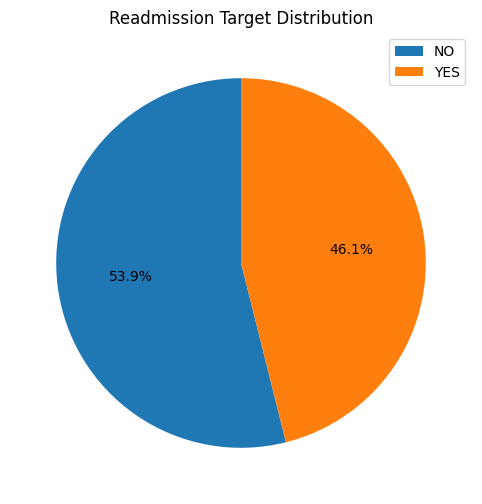

readmitted
NO     54864
YES    46902
Name: count, dtype: int64


In [37]:
# We map the target such that it is binary
df['readmitted'].replace(['>30', '<30'], 'YES', inplace = True)

#Plotting the target variable distribution
plt.figure(figsize=(8,6))
plt.pie(df['readmitted'].value_counts(), startangle=90, autopct='%1.1f%%')
plt.legend(['NO','YES'])
plt.title('Readmission Target Distribution')
plt.show()
print(df['readmitted'].value_counts())


- We can get an overview of the features from [this paper](https://www.hindawi.com/journals/bmri/2014/781670/), see table below.

- There are **missing values** in the following features:
  - `race` (`'?'`) 2273 times
  - `gender` (`'Unknown/Invalid'`) 3 times
  - `weight` (`'?'`) 98569 times
  - `payer_code` (`'?'`) 40256 times
  - `medical_specialty` (`'?'`) 49949 times
  - `diag_1` (`'?'`) 21 times
  - `diag_2` (`'?'`) 358 times
  - `diag_3` (`'?'`) 1423 times
- Looking at the IDs_mapping csv there are also **missing values** in:
  - `admission_type_id`(5:`Not Available`, 6:`NULL`, 8:`Not Mapped`) 10396 times
  - `discharge_disposition_id` (18:`NULL`, 25:`Not Mapped`, 26:`Unknown/Invalid`)  4680
  - `admission_source_id` (9:` Not Available`, 15:`Not Available`, 16:`NULL`, 20:` Not Mapped`, 21: `Unknown/Invalid`) 286 times

- There are no **missing values** in the numeric features. So we don't need to impute anything

- Two features only have one value
  - `examide` (`No`)
  - `citoglipton` (`No`)

- There is a slight **imbalance** in the target variable `readmitted` we have to take into account (46.1% readmitted)

- So far the ID mapped features are numeric but they should be treated as categorical as they have no intrinsic order (`admission_type_id`,`discharge_disposition_id`,`admission_source_id`).

- Some categorical variables have plenty of categories. Some categories of them can be combined:
  - `discharge_disposition_id`
  - `admission_source_id`
  - `Diag_1`,
  - `Diag_2`,
  - `Diag_3`

- After trying some models on the full dataset I realized that fitting the train data did not converge in reasonable time (let alone cross validation). I decided to use a subset of the data (3000 samples).

  

![table](images/table2.png)

<a id='1.3'></a>
### 1.3 Data Cleaning
dropping features, encoding features, data imputation, etc

In [39]:
# before preprocessing we keep one copy of unprocessed data
df_preprocessed = df.copy()

In [40]:
# Removing those two features because they only have one value
df_preprocessed.drop(['examide','citoglipton'], axis=1, inplace=True)

In [41]:
# Removing Patient IDs they dont help the model to generalize
df_preprocessed.drop(['patient_nbr','encounter_id'], axis=1, inplace=True)

In [42]:
# Dropping 'weight', 'payer_code', 'medical_specialty' because most entries are missing
df_preprocessed.drop(['weight','payer_code','medical_specialty'], axis=1, inplace=True)

In [43]:
# Replacing all missing values as np.nan

# '?'
features_with_questionmark = ['race','diag_1','diag_2','diag_3']
for feature in features_with_questionmark:
  df_preprocessed[feature].replace(['?'], np.nan, inplace = True)

# 'Unknown/Invalid'
df_preprocessed['gender'].replace(['Unknown/Invalid'], np.nan, inplace = True)

# missing values in ID mapped features
df_preprocessed['admission_type_id'].replace([5,6,8], np.nan, inplace = True)
df_preprocessed['discharge_disposition_id'].replace([18,25,26], np.nan, inplace = True)
df_preprocessed['admission_source_id'].replace([9,15,16,20,21], np.nan, inplace = True)
df_preprocessed['A1Cresult'].replace(np.nan, 'None', inplace=True)
df_preprocessed['max_glu_serum'].replace(np.nan, 'None', inplace=True)

In [44]:
# Mapping back admission_type_id to original categories and replacing the null values to 'Other'
df_preprocessed['admission_type_id'].replace(1, 'Emergency', inplace = True)
df_preprocessed['admission_type_id'].replace(2, 'Urgent', inplace = True)
df_preprocessed['admission_type_id'].replace(3, 'Elective', inplace = True)
df_preprocessed['admission_type_id'].replace(4, 'Newborn', inplace = True)
df_preprocessed['admission_type_id'].replace(7, 'Trauma Center', inplace = True)
df_preprocessed['admission_type_id'].replace(np.nan, 'Missing', inplace = True)

In [45]:
# Dropping all np.nan values
df_preprocessed.dropna(inplace=True)

In [46]:
print(round(1- df_preprocessed.shape[0]/df.shape[0],4)*100, "% of the entries were removed from the dataset")

8.34 % of the entries were removed from the dataset


In [47]:
# After removing the missing values 'metformin-rosiglitazone' becomes redundant and can be dropped as well
df_preprocessed['metformin-rosiglitazone'].unique()

array(['No'], dtype=object)

In [48]:
# Dropping metformin-rosiglitazone
df_preprocessed.drop(['metformin-rosiglitazone'], axis=1, inplace=True)

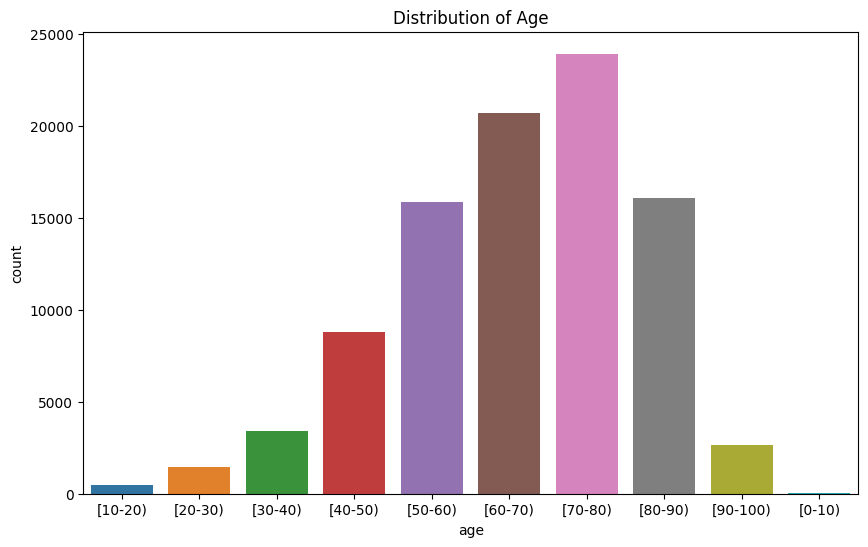

In [49]:
# Distribution of Age
plt.figure(figsize=(10,6))
sns.countplot(x='age', data=df_preprocessed)
plt.title('Distribution of Age')
plt.show()

In [50]:
# Let's map age to integers because it makes more sense to treat age as a numeric variable
# Some model (e.g. SVM, Logistic Regression) are distance sensitve and therefore age should be ordinal rather than nominal

map_age = {'[0-10)':5,
           '[10-20)':15,
           '[20-30)':25,
           '[30-40)':35,
           '[40-50)':45,
           '[50-60)':55,
           '[60-70)':65,
           '[70-80)':75,
           '[80-90)':85,
           '[90-100)':95,
}

df_preprocessed['age'].replace(map_age, inplace = True)

In [51]:
for col in ['diag_1','diag_2','diag_3']:
  print(f'Number of unique codes in {col}: {len(df_preprocessed[col].unique())}')

Number of unique codes in diag_1: 710
Number of unique codes in diag_2: 734
Number of unique codes in diag_3: 782


In [52]:
# Using the same mapping as in https://www.hindawi.com/journals/bmri/2014/781670/tab2/
diag_Circulatory_list = list(map(str,(np.append(np.arange(390,460,1),785))))
diag_Circulatory_map = {item: 'Circulatory' for item in diag_Circulatory_list}

diag_Respiratory_list = list(map(str,(np.append(np.arange(460,520,1),786))))
diag_Respiratory_map = {item: 'Respiratory' for item in diag_Respiratory_list}

diag_Digestive_list = list(map(str,(np.append(np.arange(520,580,1),787))))
diag_Digestive_map = {item: 'Digestive' for item in diag_Digestive_list}

diag_Diabetes_list = ['250', '250.01', '250.02', '250.03',
       '250.1', '250.11', '250.12', '250.13', '250.2', '250.21', '250.22',
       '250.23', '250.3', '250.31', '250.32', '250.33', '250.4', '250.41',
       '250.42', '250.43', '250.5', '250.51', '250.52', '250.53', '250.6',
       '250.7', '250.8', '250.81', '250.82', '250.83', '250.9', '250.91',
       '250.92', '250.93']
diag_Diabetes_map = {item: 'Diabetes' for item in diag_Diabetes_list}

diag_Injury_list = list(map(str,(np.arange(800,1000,1))))
diag_Injury_map = {item: 'Injury' for item in diag_Injury_list}

diag_Musculoskeletal_list = list(map(str,(np.arange(710,740,1))))
diag_Musculoskeletal_map = {item: 'Musculoskeletal' for item in diag_Musculoskeletal_list}

diag_Genitourinary_list = list(map(str,(np.append(np.arange(580,630,1),788))))
diag_Genitourinary_map = {item: 'Genitourinary' for item in diag_Genitourinary_list}

diag_Neoplasms_list = np.append(np.arange(1,280,1),[780, 781, 782, 784,])
diag_Neoplasms_list = np.append(diag_Neoplasms_list, np.arange(790,800,1))
diag_Neoplasms_list = np.delete(diag_Neoplasms_list, np.where(diag_Neoplasms_list == 250))
diag_Neoplasms_list = np.append(diag_Neoplasms_list, np.arange(680,710,1))
diag_Neoplasms_list = list(map(str,diag_Neoplasms_list))
diag_Neoplasms_map = {item: 'Neoplasms' for item in diag_Neoplasms_list}

diag_other_list = ['E812', 'E813', 'E814', 'E815', 'E816', 'E817', 'E818', 'E819',
       'E821', 'E822', 'E825', 'E826', 'E828', 'E829', 'E849', 'E850',
       'E852', 'E853', 'E854', 'E855', 'E858', 'E861', 'E864', 'E865',
       'E868', 'E870', 'E876', 'E878', 'E879', 'E880', 'E881', 'E882',
       'E883', 'E884', 'E885', 'E886', 'E887', 'E888', 'E890', 'E892',
       'E894', 'E900', 'E901', 'E904', 'E905', 'E906', 'E909', 'E912',
       'E915', 'E916', 'E917', 'E918', 'E919', 'E920', 'E922', 'E924',
       'E927', 'E928', 'E929', 'E930', 'E931', 'E932', 'E933', 'E934',
       'E935', 'E936', 'E937', 'E938', 'E939', 'E941', 'E942', 'E943',
       'E944', 'E945', 'E946', 'E947', 'E949', 'E950', 'E955', 'E956',
       'E965', 'E966', 'E968', 'E980', 'E987', 'V01', 'V02', 'V03', 'V06',
       'V07', 'V08', 'V09', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15',
       'V16', 'V17', 'V18', 'V22', 'V23', 'V25', 'V26', 'V27', 'V42',
       'V43', 'V44', 'V45', 'V46', 'V49', 'V50', 'V51', 'V53', 'V54',
       'V55', 'V56', 'V57', 'V58', 'V60', 'V61', 'V62', 'V63', 'V64',
       'V65', 'V66', 'V67', 'V69', 'V70', 'V71', 'V72', 'V85', 'V86',
       '783', '789', '365.44']
diag_other_list = np.append(diag_other_list, np.arange(280,390,1))
diag_other_list = np.append(diag_other_list, np.arange(630,680,1))
diag_other_list = np.append(diag_other_list, np.arange(740,760,1))
diag_other_list = list(map(str,diag_other_list))
diag_other_map = {item: 'Other' for item in diag_other_list}

In [53]:
# Replacing in the dataframe
for diag in ['diag_1', 'diag_2', 'diag_3']:
  df_preprocessed[diag].replace(diag_Circulatory_map, inplace = True)
  df_preprocessed[diag].replace(diag_Respiratory_map, inplace = True)
  df_preprocessed[diag].replace(diag_Digestive_map, inplace = True)
  df_preprocessed[diag].replace(diag_Diabetes_map, inplace = True)
  df_preprocessed[diag].replace(diag_Injury_map, inplace = True)
  df_preprocessed[diag].replace(diag_Musculoskeletal_map, inplace = True)
  df_preprocessed[diag].replace(diag_Genitourinary_map, inplace = True)
  df_preprocessed[diag].replace(diag_Neoplasms_map, inplace = True)
  df_preprocessed[diag].replace(diag_other_map, inplace = True)

In [70]:
import warnings

# Ignore FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn')

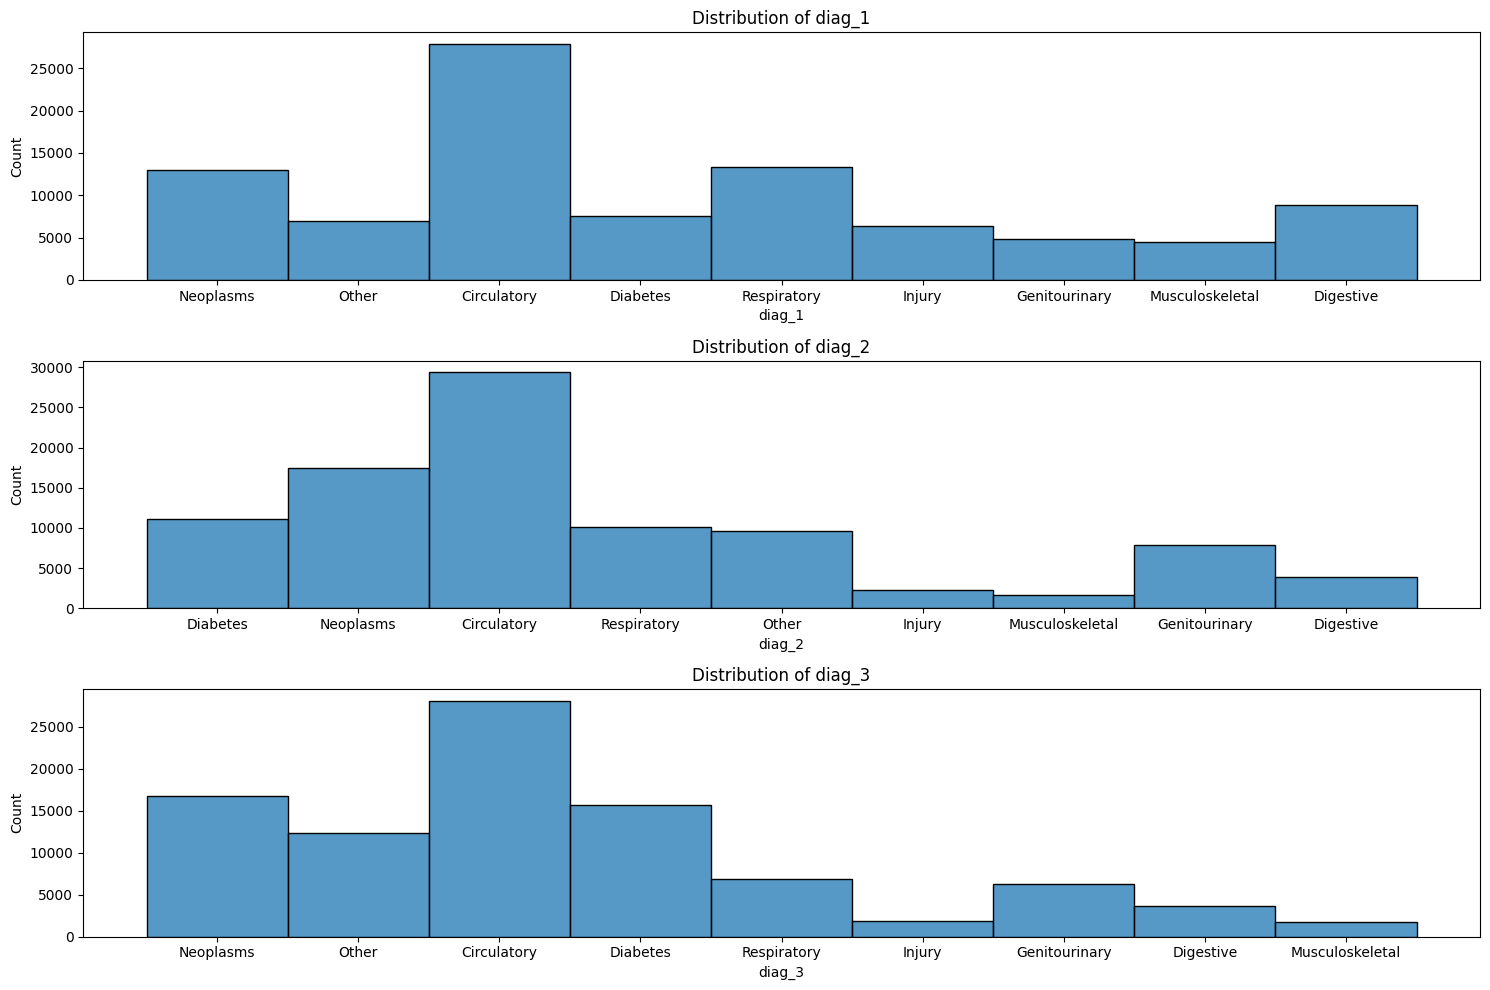

In [71]:
# Plotting the Distribution of diag_1, diag_2, diag_3 after clustering
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
sns.histplot(data=df_preprocessed['diag_1'], ax=axs[0])
axs[0].set_title('Distribution of diag_1')
sns.histplot(data=df_preprocessed['diag_2'], ax=axs[1])
axs[1].set_title('Distribution of diag_2')
sns.histplot(data=df_preprocessed['diag_3'], ax=axs[2])
axs[2].set_title('Distribution of diag_3')
plt.tight_layout()
plt.show()

In [72]:
# Unique values for gender
df_preprocessed['gender'].unique()

array([0, 1])

In [73]:
# Binary encoding gender
map_gender = {'Female':0,
             'Male':1
}

df_preprocessed['gender'].replace(map_gender, inplace = True)

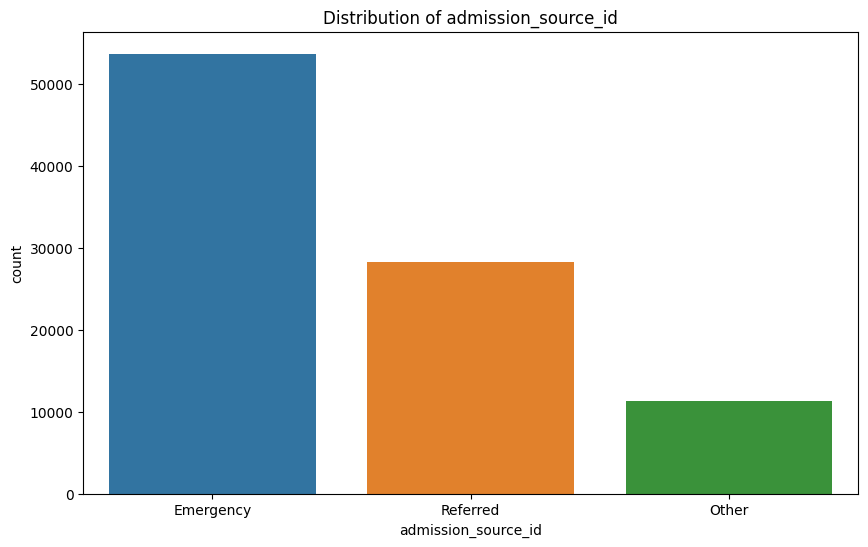

In [74]:
# Plotting admission_source_id distribution
plt.figure(figsize=(10,6))
sns.countplot(x='admission_source_id', data=df_preprocessed)
plt.title('Distribution of admission_source_id')
plt.show()

In [75]:
# Looking at the Mapping CSV this encoding seems reasonable for admission_source_id
map_admission_source_id = {1:'Referred',2:'Referred',3:'Referred',
                           4:'Other',5:'Other',6:'Other',
                           7:'Emergency',
                           8:'Other',10:'Other',11:'Other',13:'Other',14:'Other',17:'Other',22:'Other',25:'Other'}

df_preprocessed['admission_source_id'].replace(map_admission_source_id, inplace = True)

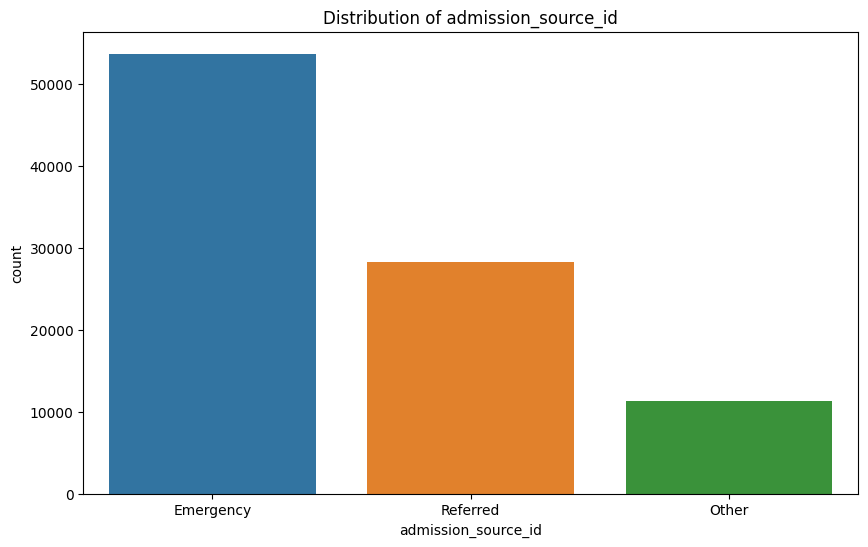

In [76]:
# Plotting admission_source_id distribution
plt.figure(figsize=(10,6))
sns.countplot(x='admission_source_id', data=df_preprocessed)
plt.title('Distribution of admission_source_id')
plt.show()

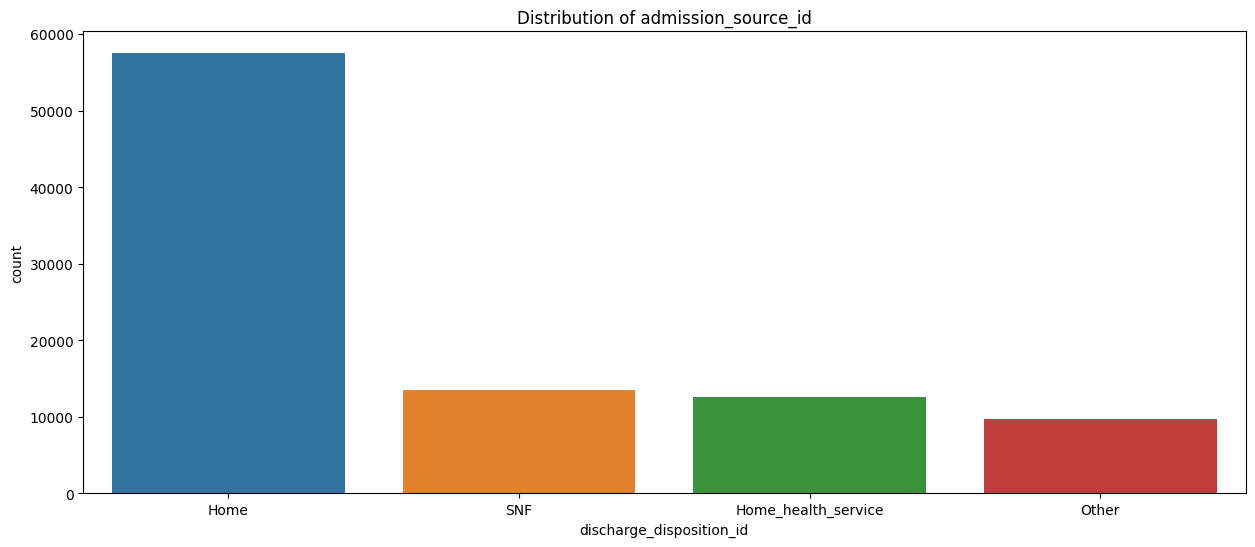

In [77]:
# Plotting discharge_disposition_id distribution
plt.figure(figsize=(15,6))
sns.countplot(x='discharge_disposition_id', data=df_preprocessed)
plt.title('Distribution of admission_source_id')
plt.show()


In [78]:
# Looking at the Mapping CSV this encoding seems reasonable for admission_source_id
map_discharge_disposition_id = {1:'Home',
                                2:'Other',
                                3:'SNF',
                                4:'Other',5:'Other',
                                6:'Home_health_service',
                                7:'Other', 8:'Other', 9:'Other',10:'Other',11:'Other',12:'Other',13:'Other',
                                14:'Other',15:'Other',16:'Other',17:'Other',19:'Other',20:'Other', 22:'Other',
                                23:'Other',24:'Other',27:'Other',28:'Other'}

df_preprocessed['discharge_disposition_id'].replace(map_discharge_disposition_id, inplace = True)

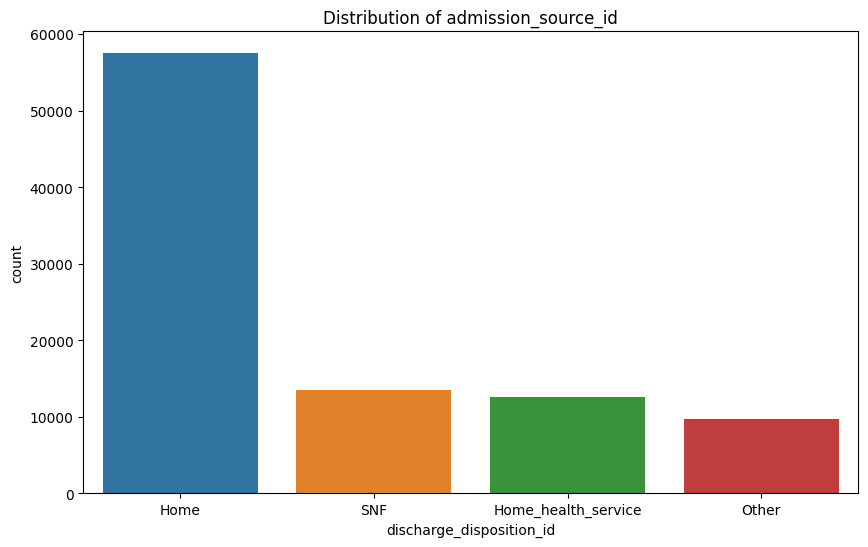

In [79]:
# Plotting discharge_disposition_id distribution
plt.figure(figsize=(10,6))
sns.countplot(x='discharge_disposition_id', data=df_preprocessed)
plt.title('Distribution of admission_source_id')
plt.show()

In [80]:
# Casting discharge_disposition_id and admission_source_id to Strings to make sure they are later one hot encoded
df_preprocessed['discharge_disposition_id'] = df_preprocessed['discharge_disposition_id'].astype('object')
df_preprocessed['admission_source_id'] = df_preprocessed['admission_source_id'].astype('object')

In [81]:
# Example for states in medication
print(df_preprocessed['insulin'].unique())

[3 0 2 1]


In [82]:
# Most medications have three different states. We interprete them numerical w.r.t to intensity
map_medications = {'No':0,     # no medication
                   'Down':1,   # reduced intensity
                   'Steady':2, # high intensity
                   'Up':3,     # increased intensity

}

In [83]:
# Mapping each medication feature accordingly
for col in df_preprocessed.columns:
  if col in medication_features:
    df_preprocessed[col].replace(map_medications, inplace=True)

In [84]:
# Updating the categorical and numeric features
categorical = df_preprocessed.drop('readmitted', axis=1).select_dtypes(include='object').columns
numeric = df_preprocessed.select_dtypes(include='int64').columns
numeric_without_medications = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
                              'num_medications', 'number_outpatient', 'number_emergency',
                              'number_inpatient', 'number_diagnoses']

Most preprocessing steps have been introduced iteratively to improve the models performance:
- Removing the features with only one value because they dont contribute any information (`examide`, `citoglipton`)
- Removing patient IDs (`encounter_id, patient_nbr`) because the models should not be trained on a patient IDs. They can obviously not genrealize to unseen data since they are always unique.
- All missing values identified earlier will be encoded as `np.nan`
- Missing values will addressed as follows:
  - `weight`, `payer_code`, `medical_specialty` are dropped because most entries are missing. Imputation would be unreasonable.
  - `admission_type_id` has more than 10000 missing values. Dropping them would mean a loss of data. We could impute them using a KNN approach but for simplicity we create an `missing` category. The other values are mapped back to their categories. (later we use one hot encoding)
  - All other missing values in `race`, `discharge_disposition_id`, `admission_source_id`, `diag_1`, `diag_2` and `diag_3` are involved in only 8.3% of the data. We can therefore remove those entries without much loss in information.

- after removing entries with missing values the `metformin-rosiglitazone` feature also becomes redundant as no patient took the medication. We will drop that feature

- Looking at some countplots we can reduce the number of categories for the following features:
  - `diag_1`, `diag_1`, `diag_3` (according to table below, [see paper](https://www.hindawi.com/journals/bmri/2014/781670/))
  - `admission_source_id`
  - `discharge_disposition_id`

- The `age` feature is originally encoded as string intervals (e.g. `[20-30]`) We use the average of each interval (e.g. `25`) to make age numeric. This way distance sensitive models like SVM or Logistic Regression can leverage information in `age` as ordinal varibale rather then categorical.

- Most features represent drugs. Their categories (mostly `No`, `Steady`, `Up`) can be interpreted as medication intensity and are therefore encoded ordinally.  

- The other preprocessing steps (encoding, scaling) will be performed after the descriptive analysis to gain more intuitive insights from the data and preprocess accordingly. We use a pipeline for that


**Disease Clusters for Diag_1, Diag_2 and Diag_3**:

![table](images/table.png)

<a id='1.4'></a>
### 1.4 Descriptive statistics

Figures/plots to explore the data

In [85]:
# Key characteristics for numeric features
df_preprocessed[numeric_without_medications].describe()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,93278.000000,93278.000000,93278.000000,93278.000000,93278.000000,93278.000000,93278.000000,93278.000000,93278.000000
mean,66.288943,4.389449,43.183194,1.340037,16.125646,0.389642,0.210339,0.649928,7.543944
std,15.637080,2.975684,19.858635,1.701060,8.058270,1.307505,0.963517,1.277761,1.820697
min,5.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,55.000000,2.000000,31.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000
50%,65.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,9.000000
75%,75.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,95.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


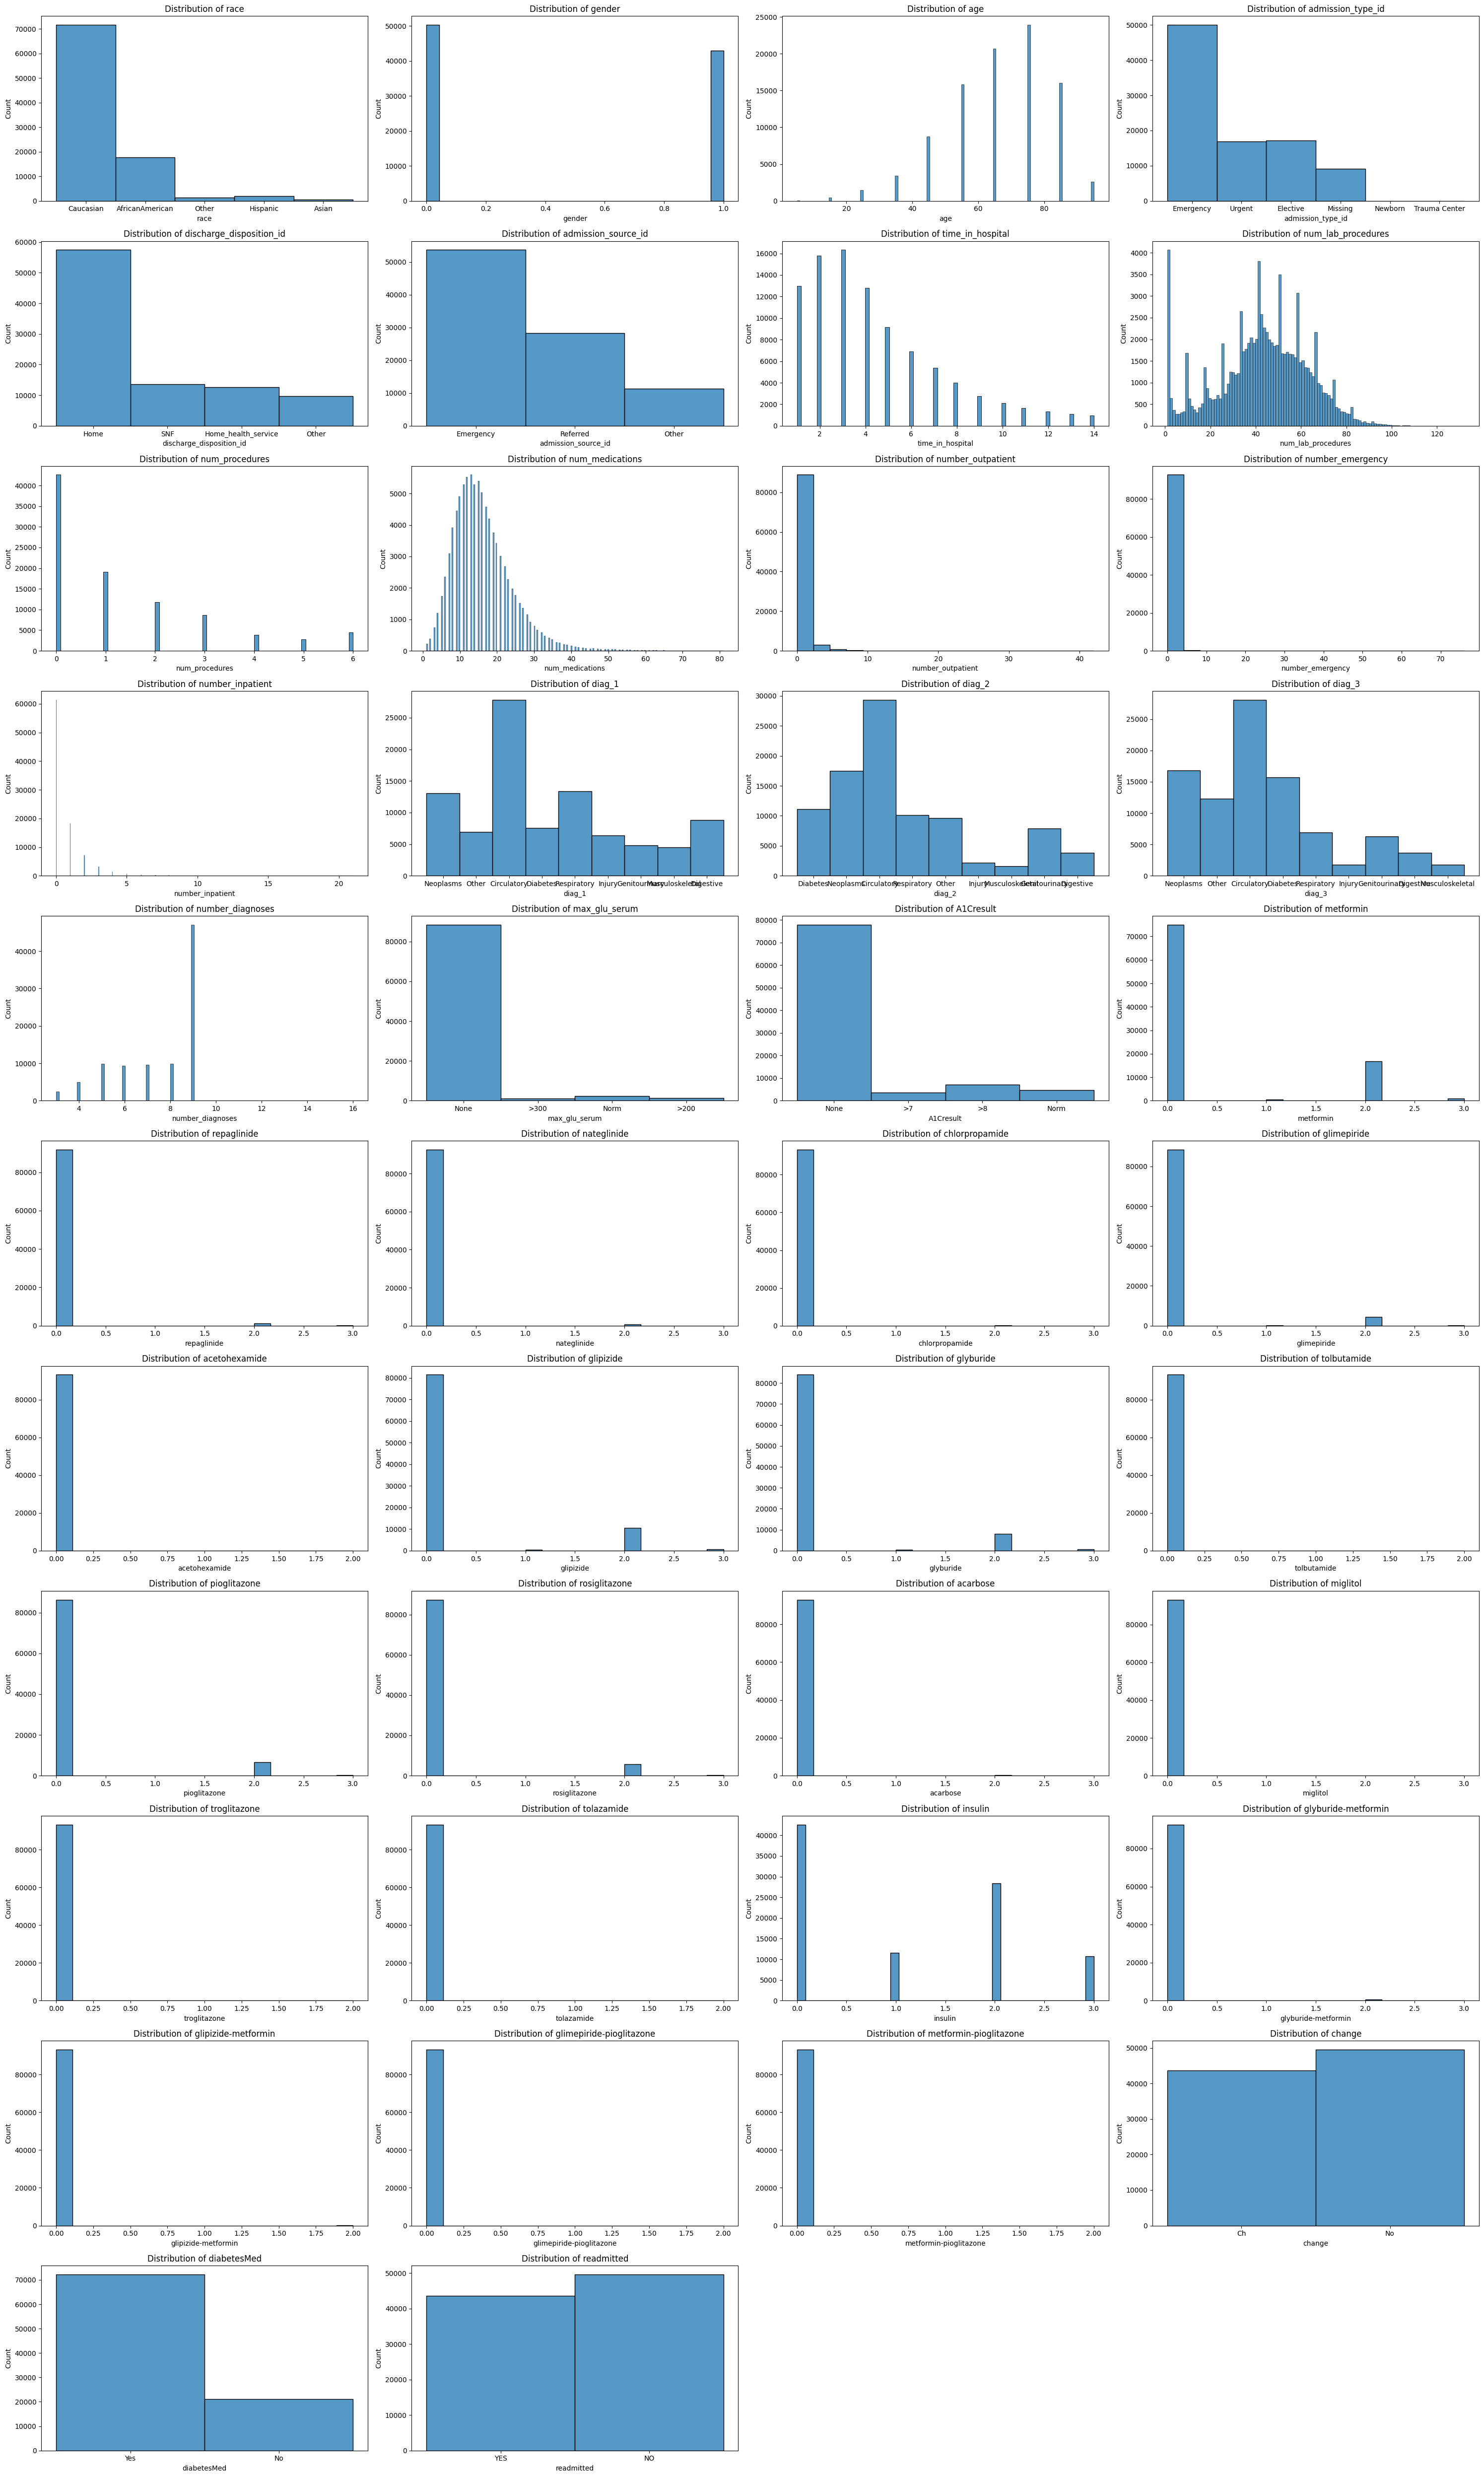

In [86]:
# Plotting the distribution of all features
plt.figure(figsize=(30,50))
for i,column in enumerate(df_preprocessed.columns):
 plt.subplot(11,4,i+1)
 plt.title(f"Distribution of {column}")
 sns.histplot(df_preprocessed[column])
 plt.tight_layout()
 plt.plot()

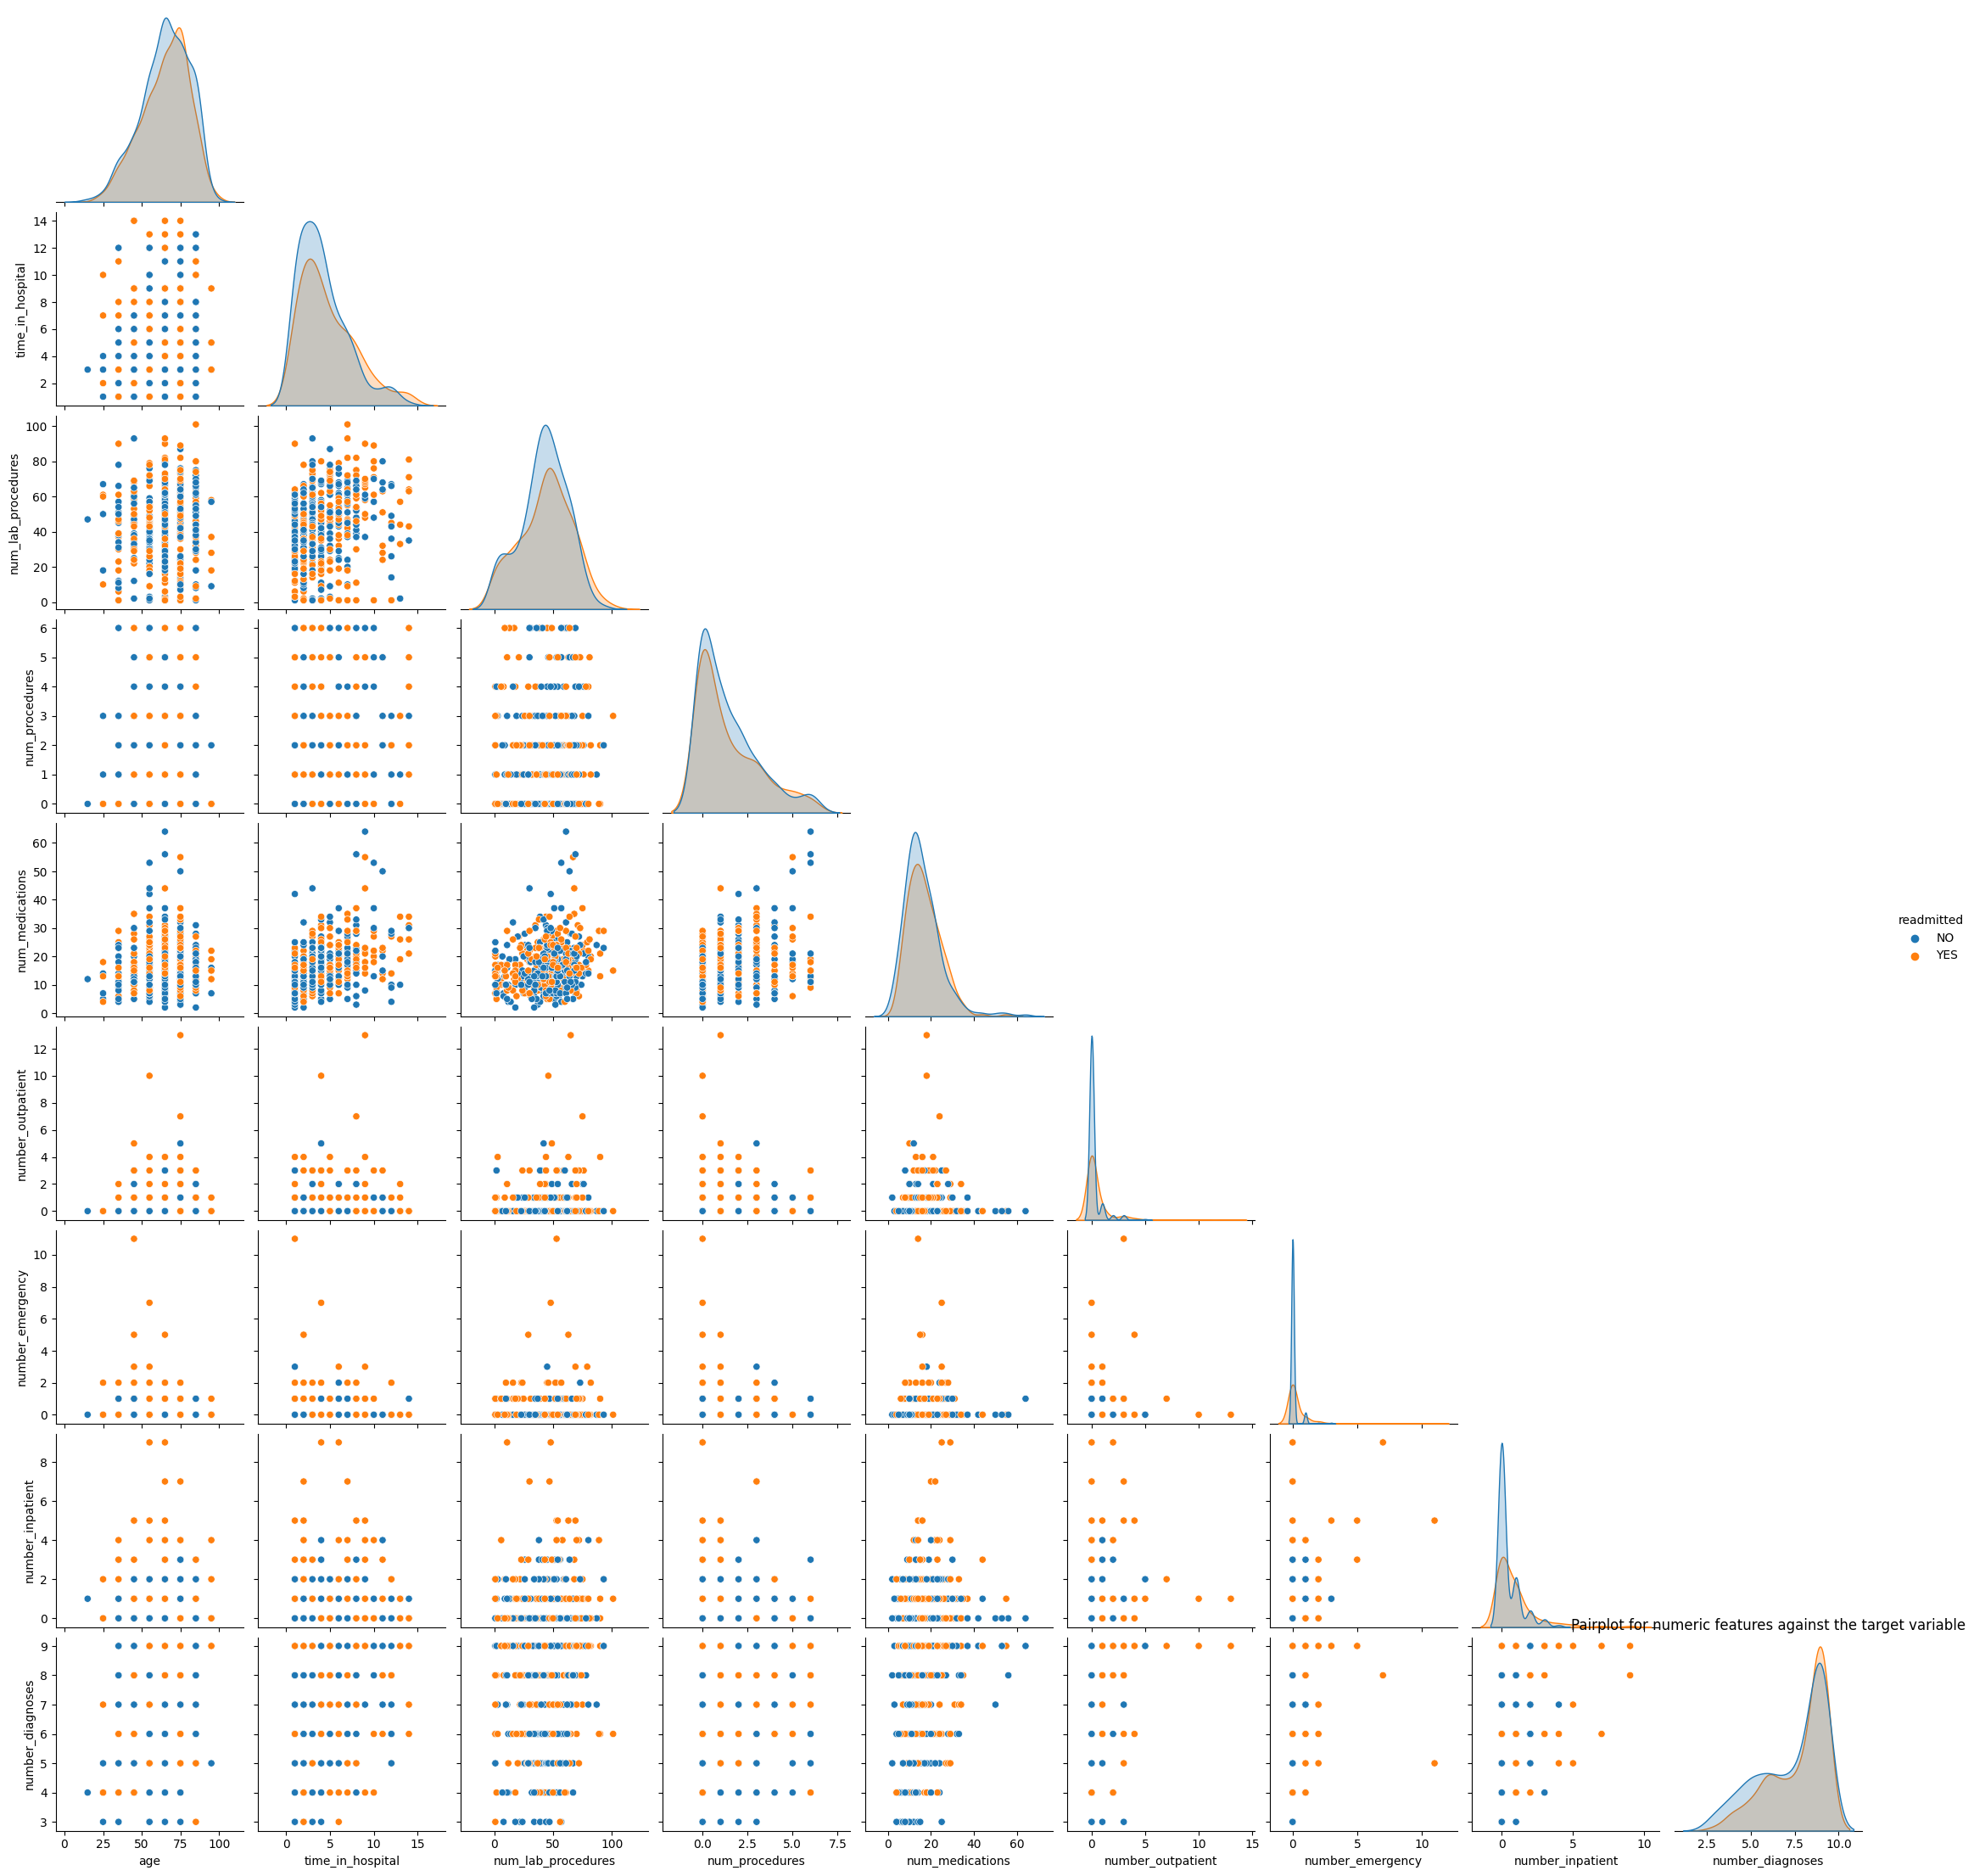

In [87]:
# Pairplotting the numeric features against the target variable, sampling a subset due to computation contraints
to_plot = numeric_without_medications + ['readmitted']
sns.pairplot(df_preprocessed[to_plot].sample(500), hue='readmitted', corner=True)
plt.title('Pairplot for numeric features against the target variable')
plt.show()

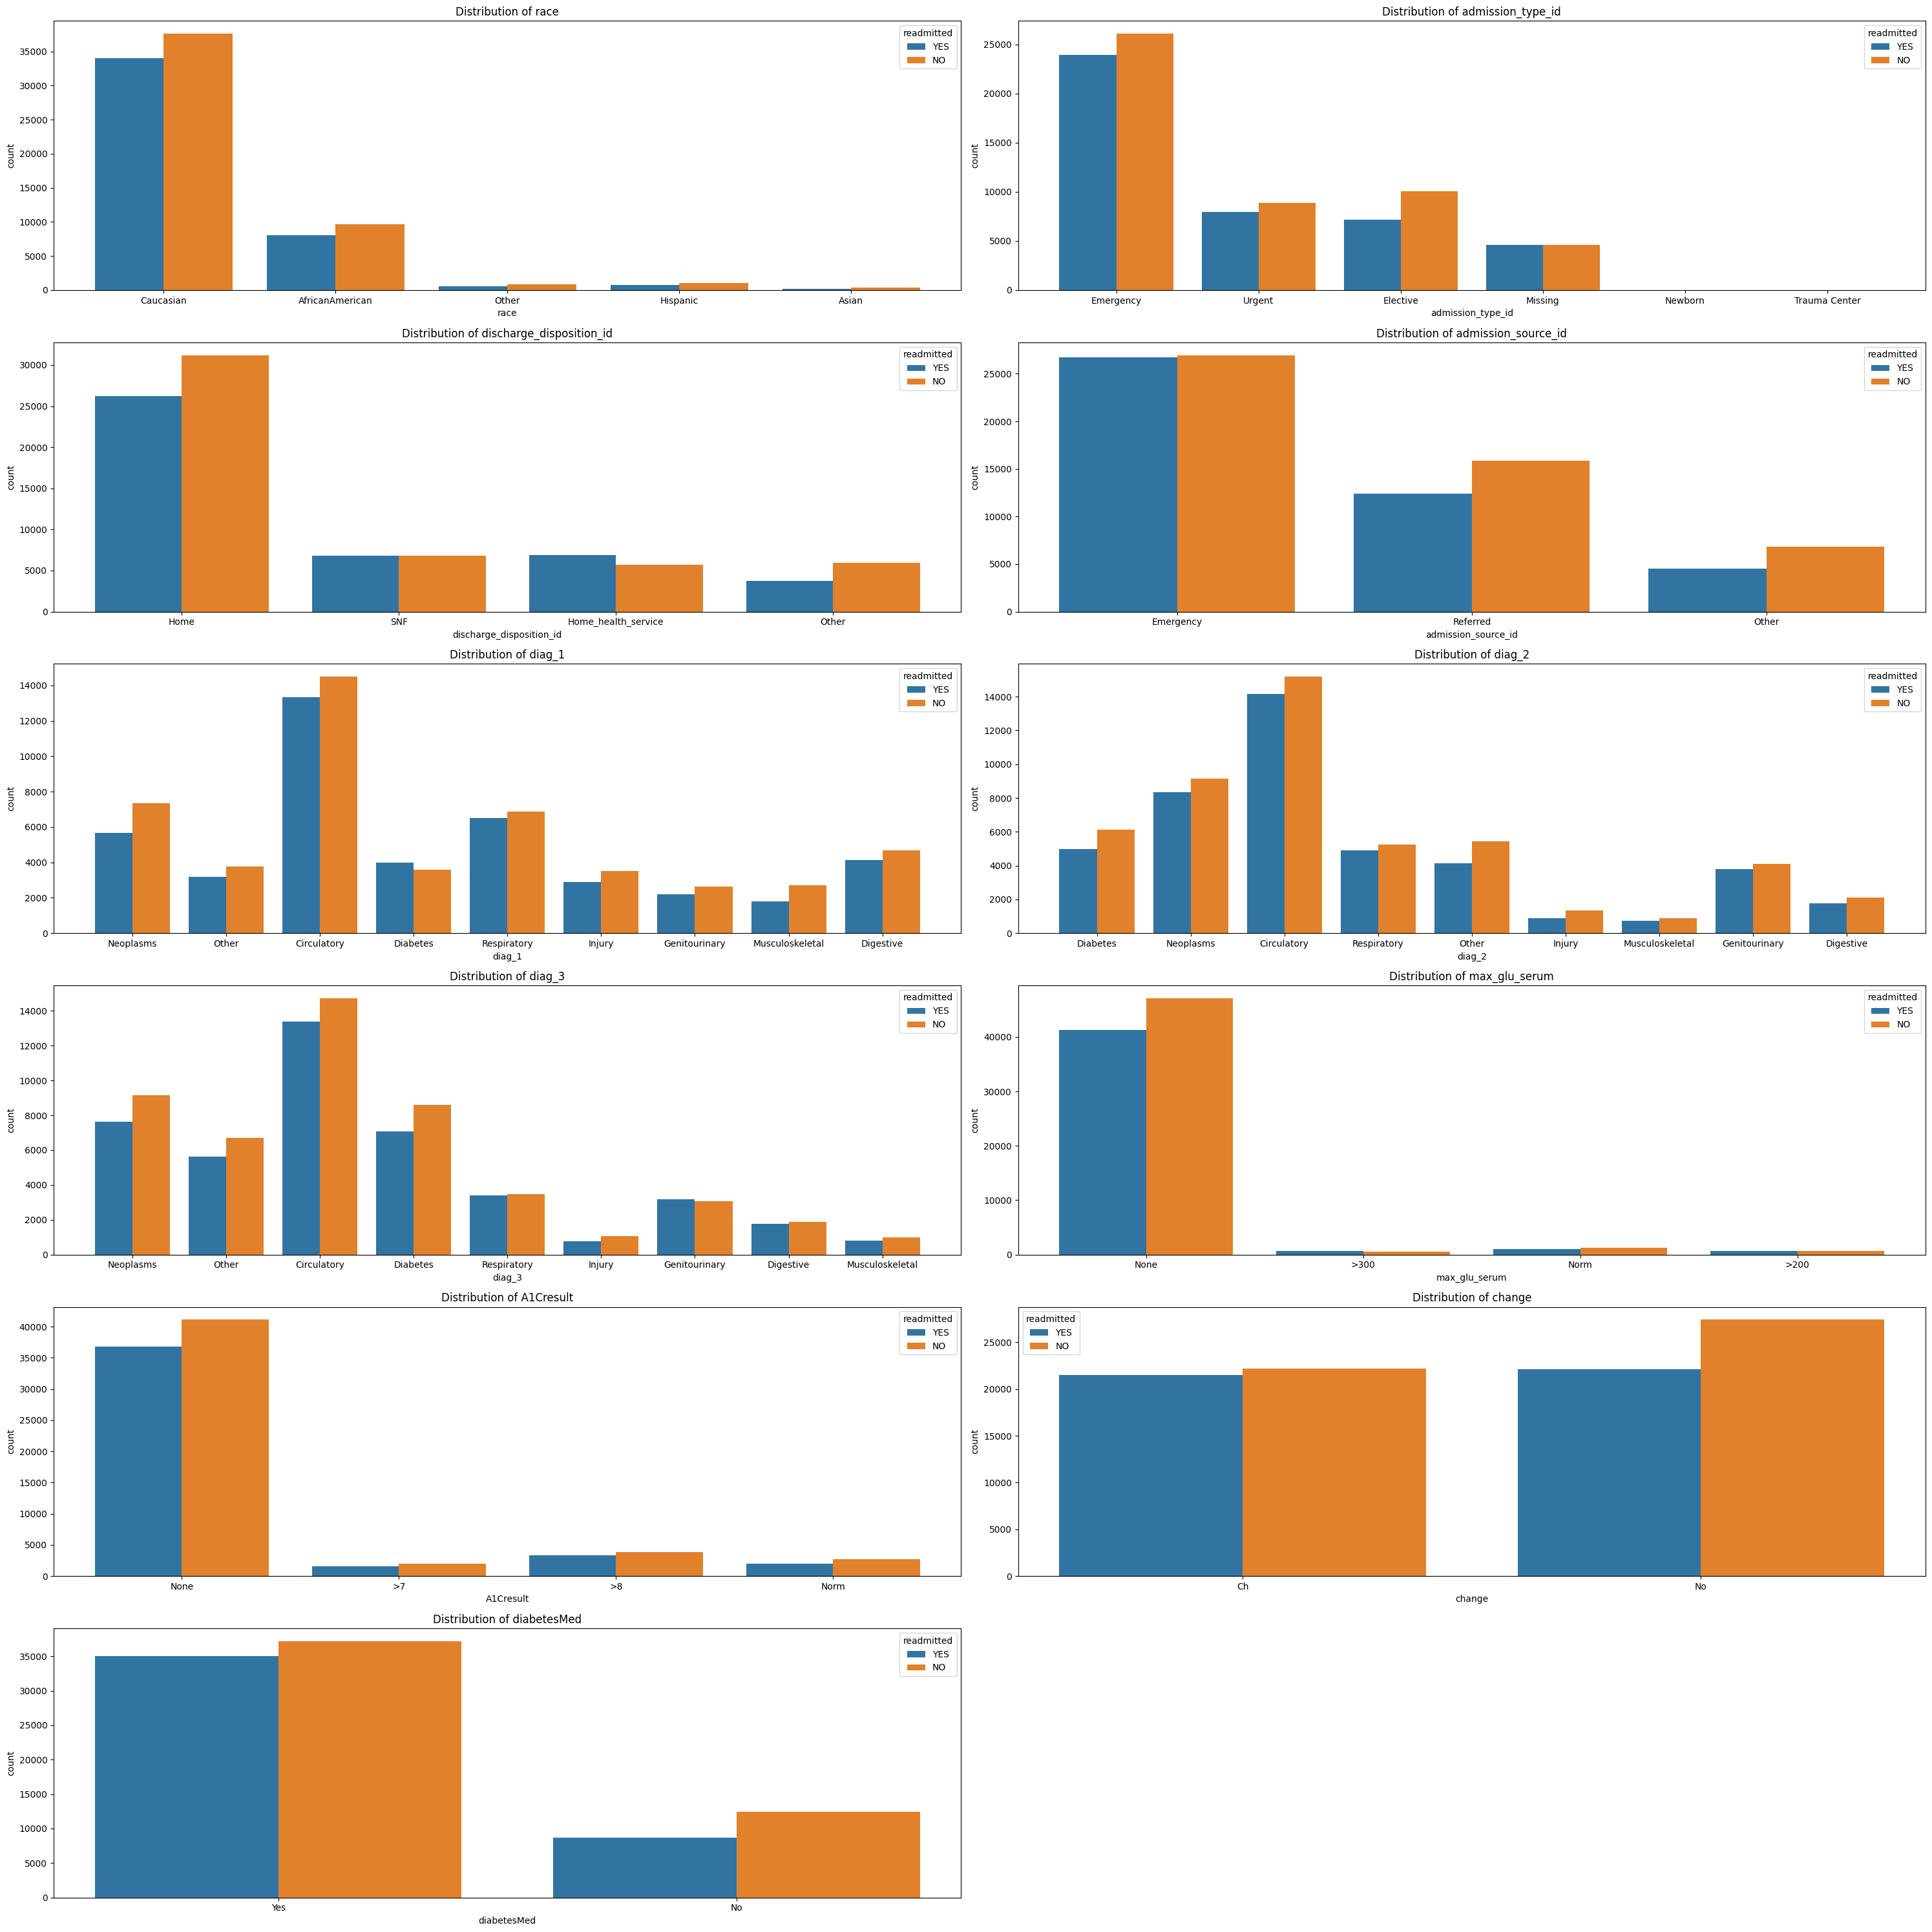

In [88]:
# Pairplotting the categorical variables against the target variable (used this bit of code before in CW2 COMP0173)
plt.figure(figsize=(30,30))
for i,column in enumerate(categorical):
    plt.subplot(6,2,i+1)
    plt.title(f"Distribution of {column}")
    ax = sns.countplot(data=df_preprocessed, x=column, hue='readmitted')
    plt.tight_layout()
    plt.plot()

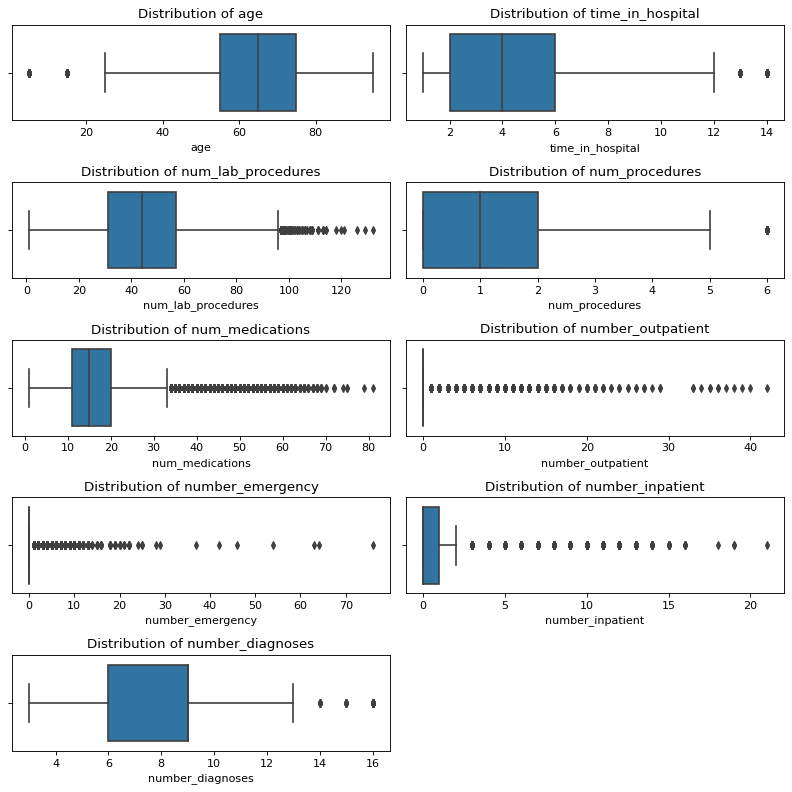

In [89]:
# Boxplotting numeric features for outlier detection
plt.figure(figsize=(10,10), dpi=80)
for i,column in enumerate(df_preprocessed[numeric_without_medications]):
 plt.subplot(5,2,i+1)
 plt.title(f"Distribution of {column}")
 ax = sns.boxplot(data=df_preprocessed, x=column)
 plt.tight_layout()
 plt.plot()

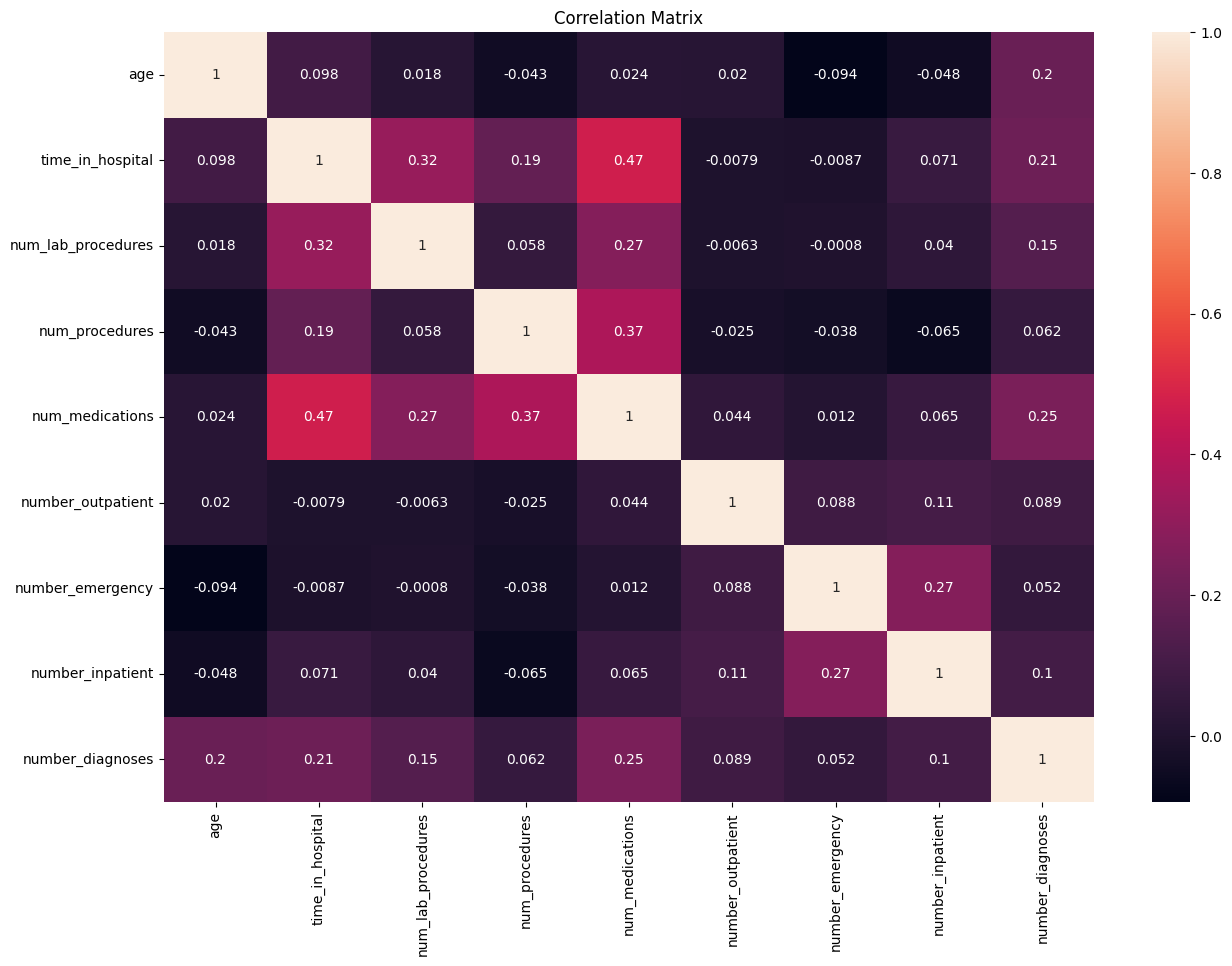

In [90]:
# Correlation plot for numeric variables
plt.figure(figsize=(15,10))
sns.heatmap(df_preprocessed[numeric_without_medications].corr(),annot = True)
plt.title('Correlation Matrix')
plt.show()

**Key insights from Despriptive Analysis**:
- Race is US typical distributed (77% `Caucasian`, 19% `AfricanAmerican`)
- gender is fairly balanced between `male` and `female`
- age is slightly skewed towards older people (mean of 66)
- most admission types are `Emergency`
- time spent in hospital is left skewed with mean of 4.38 days
- `num_medication` is normally distributed with mean of 16
- all features indicating medications are extremely imbalanced towards `No` (low variance). But the features will be kept because the few positive cases may be valuable for model training.

- There seem to be no linear seperatability for the numeric features. Non Linear or Kernel models might be useful to find non linear pattern.

- For the categorical features there is hardly any trend regarding the target variable. One observation is that the proportion of those that were readmitted for `admisstion_type = Home_health_service` is higher for readmitted patients than those that are not readmitted.

- from the boxplots we find that the ranges of values for the numeric variables seem reasonable and no outliers need to be imputed.

- From the correlation plot we find that there is a strong correlation between the time spent in the hospital and the number of medications (0.47). Other notable correlations are between number of precedures and number of medications (0.37) and time in hospital and number of lab procedures (0.32)

In conclusion, from the descriptive anlysis it is hard to find any patterns with respect to readmission. That is reflected by the rather poor performance of the classifiers. Domain knowlegde and appropriate Feature Engineering could help leverage the dataset.

<a id='2'></a>
# 2. Data Assembling and Preprocessing

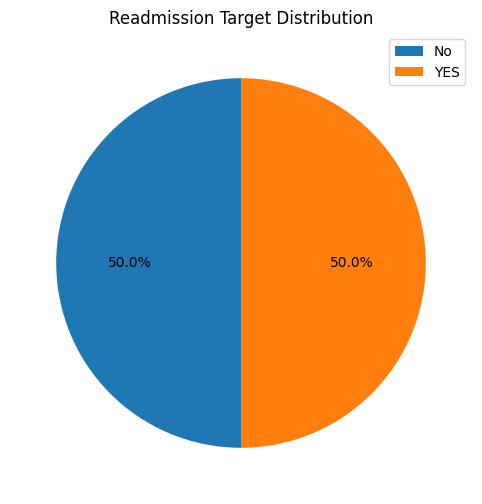

readmitted
NO     1500
YES    1500
Name: count, dtype: int64


In [91]:
# First we downsample the dataset to 3000 sample and balance the target classes
from sklearn.utils import resample

# define subset size
size = 3000

readmitted = df_preprocessed[df_preprocessed['readmitted'] == 'YES']
not_readmitted  = df_preprocessed[df_preprocessed['readmitted'] == 'NO']

# Randomly sample from each class
not_readmitted_downsample = resample(not_readmitted,
             replace=True,
             n_samples=int(size/2),
             random_state=42)

readmitted_downsample = resample(readmitted,
             replace=True,
             n_samples=int(size/2),
             random_state=42)

df_preprocessed_balanced = pd.concat([readmitted_downsample, not_readmitted_downsample])

#Shuffeling
df_preprocessed_balanced = df_preprocessed_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_preprocessed = df_preprocessed_balanced.copy()

# Plotting the target distribution
plt.figure(figsize=(8,6))
plt.pie(df_preprocessed_balanced['readmitted'].value_counts(), startangle=90, autopct='%1.1f%%')
plt.legend(['No','YES'])
plt.title('Readmission Target Distribution')
plt.show()
print(df_preprocessed_balanced['readmitted'].value_counts())


In [92]:
# After downsampling some medications were never given (only 'No' category).
# These features are therefore redundant and can be dropped
for col in df_preprocessed:
  if len(df_preprocessed[col].unique())==1:
    print('Unique categories of ', col, ': ', df_preprocessed[col].unique(), '\n')
    df_preprocessed.drop(col, axis=1, inplace=True)

Unique categories of  acetohexamide :  [0] 

Unique categories of  troglitazone :  [0] 

Unique categories of  glipizide-metformin :  [0] 

Unique categories of  glimepiride-pioglitazone :  [0] 

Unique categories of  metformin-pioglitazone :  [0] 



In [93]:
# Updating the categorical and numeric features
categorical = df_preprocessed.drop('readmitted', axis=1).select_dtypes(include='object').columns
numeric = df_preprocessed.select_dtypes(include='int64').columns

In [94]:
# Printing all features that will be used
print('Categorical Features: \n', categorical, '\n')
print('Numeric Features: \n', numeric)

Categorical Features: 
 Index(['race', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
       'A1Cresult', 'change', 'diabetesMed'],
      dtype='object') 

Numeric Features: 
 Index(['gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin',
       'glyburide-metformin'],
      dtype='object')


In [95]:
# Importing preprocessing and pipeline libraries
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer

In [96]:
# The preprocessing is not yet applied as we use sklearn Pipeline to perform all step at once
X = df_preprocessed.drop('readmitted', axis=1)

# Encoding the target variable, NO: 0, YES: 1
y = LabelEncoder().fit_transform(df_preprocessed['readmitted'])

In [97]:
# The data and target shape
print('Shape of data: ', X.shape)
print('Shape of labels: ', y.shape)

Shape of data:  (3000, 36)
Shape of labels:  (3000,)


In [98]:
# Here we set up the preprocessing pipeline.
# Later in Cross Validation the preprocessor will be applied on the train set using fit_transform() and transform() on the test set
# to avoid data leakage
def setup_preprocessor(df):

  # Removing the target
  data= df_preprocessed.drop('readmitted',axis=1)

  # Defining categorical and numeric features
  categorical_cols = data.columns[(data.dtypes=='object')].tolist()
  num_cols = data.select_dtypes(include='int64').columns.tolist()

  # One hot encoded variables
  ohe_unique_list = [data[c].unique().tolist() for c in categorical_cols]
  ohe = OneHotEncoder(categories=ohe_unique_list)

  # Standardizing numeric variables
  ss = StandardScaler()

  preprocessor = make_column_transformer(
      #(oe, oe_cols),
      (ohe, categorical_cols),
      (ss, num_cols),
      remainder='passthrough'
  )

  return preprocessor

- First we are downsample the dataset and balance the target variable while keeping the original feature distribution (by sampling randomly from each class)
- By downsampling some features become redundant and will be removed.
- We split the dataset in data and labels. Later the data will be further split into train, validation and test set in the cross validation pipeline.
- The preprocessing pipeline has two steps:
  - **One Hot Encoding** for the categorical features. We don't use Ordinal Encoding because all categorical features have no intrinsic order. Since some models use distance metrics (e.g. SVM) Ordinal Encoding would only make sense if categories can be ordered which is not the case (e.g. `race`)
  - **StandardScaler** for numeric variables, i.e. centering the data with mean 0 and standard deviation of 1 which specifically helps linear models such as SVM or Linear Regression assuming normally distributed features.

- The encoding and scaling is fitted only on training data to avoid data leakage. Then both train and test data is transformed accordingly. These steps are included in the cross validation pipeline

<a id='3'></a>
# 3 Machine Learning Pipeline


<a id='3.1'></a>
### 3.1 Models

In [99]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [100]:
svm = SVC()
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
models = [svm, lr, dt, rf, gb]

In [101]:
def setup_pipe(preprocessor, estimator):
  '''
  Function that takes
    1. preprocessor from the setup_preprocessor function
    2. an sklearn model
  and returns:
    Pipeline object that can be fitted
  '''

  steps = [
      ('preprocess', preprocessor),
      ('clf', estimator)
  ]

  pipe = Pipeline(steps)

  return pipe

Since the task is predicting readmission the underlying problem is a **Supervised Classification Problem**.

We use the following models
- **Support Vector Machine** as a Baseline. SVM is effective on high dimensional data. After One hot encoding there will be a high number of features which SVM can easily handle. Additionally the EDA part shows that the data is hard to separate linearly. SVM can identify more complex patterns using the kernel trick (potentiall rbf kernel)
- **Logistic Regression**: is simple and interpretable. However Logistic Regression might have difficulties with non linear data. If all models perform equally Logistic Regression should be picked because of its simplicity.
- **Decision Tree**: Similarily the strength of Decsion Trees is their simplicity and interpretability. However,compared to Logistic Regression Decision Trees can identify non linear patterns which seems helpful. Decsion Trees can be plotted as well which helps for transparency
- **Random Forest**: Decision Trees normally have high variance. As Random Forest use bagging techniques it can help reduce the variance and is thereby also more robust to overfitting. Random Forest are also generally performing well on tabular data.
- **Gradient Boosting**: Lastly I picked Gradient Boosting for is high predictive power. Similar to Random Forest multiple Decision Tress are combined but Gradient Booting combines them sequentially to improve on previous misclassifications.

I mostly choose Tree based models because for tabular data they often still outperform more complex models like neural networks (see [Why do tree-based models still outperform deep learning on tabular data?](https://arxiv.org/pdf/2207.08815.pdf)


<a id='3.2'></a>
### 3.2 Metrics

In [102]:
# Importing performance measures
from sklearn.metrics import accuracy_score, f1_score


- Since the dataset is perfectly balanced after we downsampled we can use **`accuracy`** as primary performance metric. The hyperparameters will be optimzed on accuracy. Its very interpretable and easy to compare with other models. If the target was imbalanced I would have choosen `balanced_accuarcy_score`.
- To make sure the models not only perform well on one class while performing poor on the other we will also report **`f1_score`** on the test set prediction. F1 scores provide a more balanced measure of performance between percision and recall.

<a id='3.3'></a>
### 3.3 Cross-Validation

Implementing a cross-validation (CV) pipeline to optimize the models’ hyperparameters considering the data properties The CV pipeline provides multiple estimations of performance for a particular model to provide mean and standard deviation. 

In [118]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RepeatedKFold, KFold, cross_val_score, RandomizedSearchCV, StratifiedKFold

In [119]:
# Defining the grid search space for all classifiers. Can be extended. That's why I leave the comments
grids = [

    #SVM
    {
      'clf__C': [0.6, 0.8, 1],
      #'clf__gamma': [0.1,1],
      'clf__kernel': ['rbf', 'linear'], # coefficients can only be extracted with linear kernel
     },

     #LogisticRegression
     {
      'clf__max_iter':[1000],
      'clf__C': [0.05, 0.1, 0.5, 1],
      #'clf__penalty': ['l2'],
      #'clf__solver': ['lbfgs'],
     },

     #DecisionTreeClassifier
     {
      'clf__max_depth':[3,5,7],
      #'clf__min_samples_split':[2,5],
      'clf__min_samples_leaf':[1,5,10]

     },

      #RandomForestClassifier
     {
      'clf__n_estimators': [50, 100],
      #'clf__criterion': ['gini', 'entropy'],
      'clf__max_depth': [10, 20],
      'clf__min_samples_split': [50],
      #'clf__min_samples_leaf': [1, 2, 4],
      'clf__random_state': [42]
     },

     #GradientBoostingClassifier
     {
      'clf__n_estimators': [50,100,200],
      #'clf__learning_rate': [0.01],
      'clf__max_depth': [2, 3],
      #'clf__min_samples_split': [2, 5, 10],
      #'clf__min_samples_leaf': [1, 2, 4],
      #'clf__subsample': [0.5, 0.8, 1.0],
     },


]

In [105]:
# Nested Cross Validation
def cv_nested(estimator, param_gird, n_splits_outer=3, n_splits_inner=3, verbose=True):
  # some inspiration is taken from https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
  '''
    Takes:
      1. estimator that is returned from the setup_pipe() method. Or any classifier that implements a fit method
      2. paramameter gird for GridSearch. If pipeline is used all parmeter names should have 'clf__' in front
      3. n_splits_outer: number of folds for outer loop (default 3)
      4. n_splits_innner: number of folds for inner loop (default 3)
      5. verbose: boolean for printing results
  '''
  # Outer Cross Validation for performance estimation, Stratified to make sure target is balanced in each split
  cv_outer = StratifiedKFold(n_splits=n_splits_outer, shuffle=True, random_state=1)

  # saving results
  acc_results_train = list()
  acc_results_test = list()
  f1_results_test = list()
  best_models = list()

  # splitting the data in train and test data for each outer fold
  for i, (train_ix, test_ix) in enumerate(cv_outer.split(X,y)):

    # Train Test Split
    X_train_cv, X_test_cv = X.iloc[train_ix], X.iloc[test_ix]
    y_train_cv, y_test_cv = y[train_ix], y[test_ix]

    # Inner Cross Validation Loop for Hyperparameter Tuning, also stratified
    cv_inner = StratifiedKFold(n_splits=n_splits_inner, shuffle=True, random_state=1)

    # Creating GridSearchCV object and optimizing on 'accuracy'
    search = GridSearchCV(estimator, param_gird, scoring='accuracy', cv=cv_inner)
    # execute search
    result = search.fit(X_train_cv, y_train_cv)
    # get the best performing model
    best_model = result.best_estimator_

    # evaluate model for train and test accuracy
    ypred_train = best_model.predict(X_train_cv)
    ypred_test = best_model.predict(X_test_cv)

    # accuracy
    acc_train = accuracy_score(y_train_cv, ypred_train)
    acc_test = accuracy_score(y_test_cv, ypred_test)

    #f1
    f1_test = f1_score(y_test_cv, ypred_test)

    # store the result
    acc_results_train.append(acc_train)
    acc_results_test.append(acc_test)
    f1_results_test.append(f1_test)

    best_models.append(best_model)

    if verbose:
      # report progress
      print('-Fold %d: Train Acc: %.3f, Test Acc: %.3f, Test f1: %.3f, Best hyperparamters  = %s' % (i+1, acc_train, acc_test, f1_test, result.best_params_))

  # return the model with best test accuracy
  index = acc_results_test.index(max(acc_results_test))
  final_model = best_models[index]

  return final_model, acc_results_train, acc_results_test, f1_results_test



In [106]:
# Setting up the preprocessor pipeline
preprocessor = setup_preprocessor(df_preprocessed)

#storing results
means_train = []
stds_train = []
means_test = []
stds_test = []
final_models = []
f1_means = []
f1_stds_test = []


for i, model in enumerate(models):

  #Parameter Grid
  param_grid = grids[i]

  #Printing the model
  print(model)

  #Estimator pipeline
  estimator = setup_pipe(preprocessor, model)

  # Nested Cross Validation
  final_model, acc_results_train, acc_results_test, f1_results_test = cv_nested(estimator, param_grid)

  # Train Accuracy
  model_mean_train = np.mean(acc_results_train)
  means_train.append(model_mean_train)
  model_std_train = np.std(acc_results_train)
  stds_train.append(model_std_train)

  # Test Accuracy
  model_mean_test = np.mean(acc_results_test)
  means_test.append(model_mean_test)
  model_std_test = np.std(acc_results_test)
  stds_test.append(model_std_test)

  # F1 score
  model_f1_mean = np.mean(f1_results_test)
  f1_means.append(model_f1_mean)
  f1_model_std_test = np.std(f1_results_test)
  f1_stds_test.append(f1_model_std_test)

  # Best performing Model
  final_models.append(final_model)

  print('Mean Train Acc: %.3f (Std: %.3f), Mean Test Acc: %.3f (Std: %.3f), Mean Test f1: %.3f (Std: %.3f)'
        % (model_mean_train, model_std_train, model_mean_test, model_std_test, model_f1_mean, f1_model_std_test), '\n')


SVC()
-Fold 1: Train Acc: 0.751, Test Acc: 0.598, Test f1: 0.581, Best hyperparamters  = {'clf__C': 1, 'clf__kernel': 'rbf'}
-Fold 2: Train Acc: 0.656, Test Acc: 0.588, Test f1: 0.558, Best hyperparamters  = {'clf__C': 0.6, 'clf__kernel': 'linear'}
-Fold 3: Train Acc: 0.733, Test Acc: 0.601, Test f1: 0.573, Best hyperparamters  = {'clf__C': 0.8, 'clf__kernel': 'rbf'}
Mean Train Acc: 0.713 (Std: 0.041), Mean Test Acc: 0.596 (Std: 0.006), Mean Test f1: 0.571 (Std: 0.010) 

LogisticRegression()
-Fold 1: Train Acc: 0.643, Test Acc: 0.625, Test f1: 0.606, Best hyperparamters  = {'clf__C': 0.05, 'clf__max_iter': 1000}
-Fold 2: Train Acc: 0.657, Test Acc: 0.580, Test f1: 0.554, Best hyperparamters  = {'clf__C': 0.1, 'clf__max_iter': 1000}
-Fold 3: Train Acc: 0.641, Test Acc: 0.617, Test f1: 0.596, Best hyperparamters  = {'clf__C': 0.1, 'clf__max_iter': 1000}
Mean Train Acc: 0.647 (Std: 0.007), Mean Test Acc: 0.607 (Std: 0.020), Mean Test f1: 0.585 (Std: 0.022) 

DecisionTreeClassifier()
-Fold

In [107]:
df_results = pd.DataFrame({
  'Best Model':list(map(str,[model['clf'] for model in final_models])),
  'Mean Test Accuracy':means_test,
  'Standard Deviation Test':stds_test,
  'Mean Train Accuracy':means_train,
  'Standard Deviation Train':stds_train,
  'Mean Test F1 Score': f1_means,
  'Standard Deviation F1 Score': f1_stds_test,
})

In [108]:
df_results

,Best Model,Mean Test Accuracy,Standard Deviation Test,Mean Train Accuracy,Standard Deviation Train,Mean Test F1 Score,Standard Deviation F1 Score
0,SVC(C=0.8),0.595667,0.005558,0.713500,0.041354,0.570817,0.009672
1,"LogisticRegression(C=0.05, max_iter=1000)",0.607333,0.019602,0.647167,0.006980,0.585128,0.022297
2,"DecisionTreeClassifier(max_depth=3, min_sample...",0.584000,0.001633,0.615167,0.018661,0.503416,0.077284
3,"RandomForestClassifier(max_depth=10, min_sampl...",0.623333,0.004497,0.772833,0.021872,0.609214,0.003197
4,"GradientBoostingClassifier(max_depth=2, n_esti...",0.614667,0.014522,0.682333,0.037887,0.585168,0.014891


**CV Pipeline**
- We are using **Nested Cross Validation**
- That means we have an inner and an outer loop:
  - The outer loop is used for performance estimation. We use three folds to evaluate a model on three different test sets. This will lead to a more robust estimation (mean and standard deviation). The folds are stratified w.r.t to the target class such that train and test sets are balanced.
  - The inner loop performs grid search CV for hyperparameter tuning. The current train set is again split into a train and validation set (repeated for 5 folds). The best resulting estimator will be saved and evaluated on the current test set.

- The pipeline object will make sure that the preprocessing steps are only fitted on train data and not on test data to avoid data leakage

- This approach has two caveats:
  - Computationally expensive. The model has to be fit `n*m*l` times (`n`: number of combinations for grid search, `m`: number of folds for inner loop, `l`: number of folds for outer loop).
  - We don't have a single final model because the optimal model depends on the current training set (We select the model with highest test accuracy within the outer loop).

- To mitigate the computation issues:
  - We optimized for a small set of hyperparameters
  - Use a small subset of the full dataset
  - The apporach can easily be scaled up for more hyperparameters (bigger grids are provided) and larger datasets if the computational ressources are avaiable.


<a id='3.4'></a>
### 3.4 Plotting Hyperparameters against Performance

- For visualization purposes we only vary one hyperparameter for each model.



In [109]:
def evaluate(estimator, n_splits_outer=3):

  # configure the cross-validation procedure
  cv_outer = StratifiedKFold(n_splits=n_splits_outer, shuffle=True, random_state=1)
  # enumerate splits
  results_train = list()
  results_test = list()

  for i, (train_ix, test_ix) in enumerate(cv_outer.split(X,y)):
    # split data
    X_train_cv, X_test_cv = X.iloc[train_ix], X.iloc[test_ix]
    y_train_cv, y_test_cv = y[train_ix], y[test_ix]
    estimator.fit(X_train_cv, y_train_cv)
    # evaluate model on the hold out dataset
    ypred_train = estimator.predict(X_train_cv)
    ypred_test = estimator.predict(X_test_cv)
    # evaluate the model
    acc_train = accuracy_score(y_train_cv, ypred_train)
    acc_test = accuracy_score(y_test_cv, ypred_test)
    # store the result
    results_train.append(acc_train)
    results_test.append(acc_test)
    # report progress

  return results_train, results_test


In [110]:
def hyperparameter_plot(param_values, means_train, means_test, stds_train, stds_test, estimator_name, hyperparameter_name):
  '''
    plot the estimator performance (train and test accuracy) against one hyperparmeter
  '''
  plt.figure(figsize=(15,8))
  plt.errorbar(x= param_values, y = means_train, yerr=stds_train, fmt='o', capsize=5, label='Train Accuracy', linestyle='-')
  plt.errorbar(x= param_values, y = means_test, yerr=stds_test, fmt='o', capsize=5, label='Test Accuracy', linestyle='-')
  plt.legend()
  plt.title(f'{estimator_name} Hyperparameter against performance')
  plt.xlabel(hyperparameter_name)
  plt.ylabel('accuracy')

  plt.show()


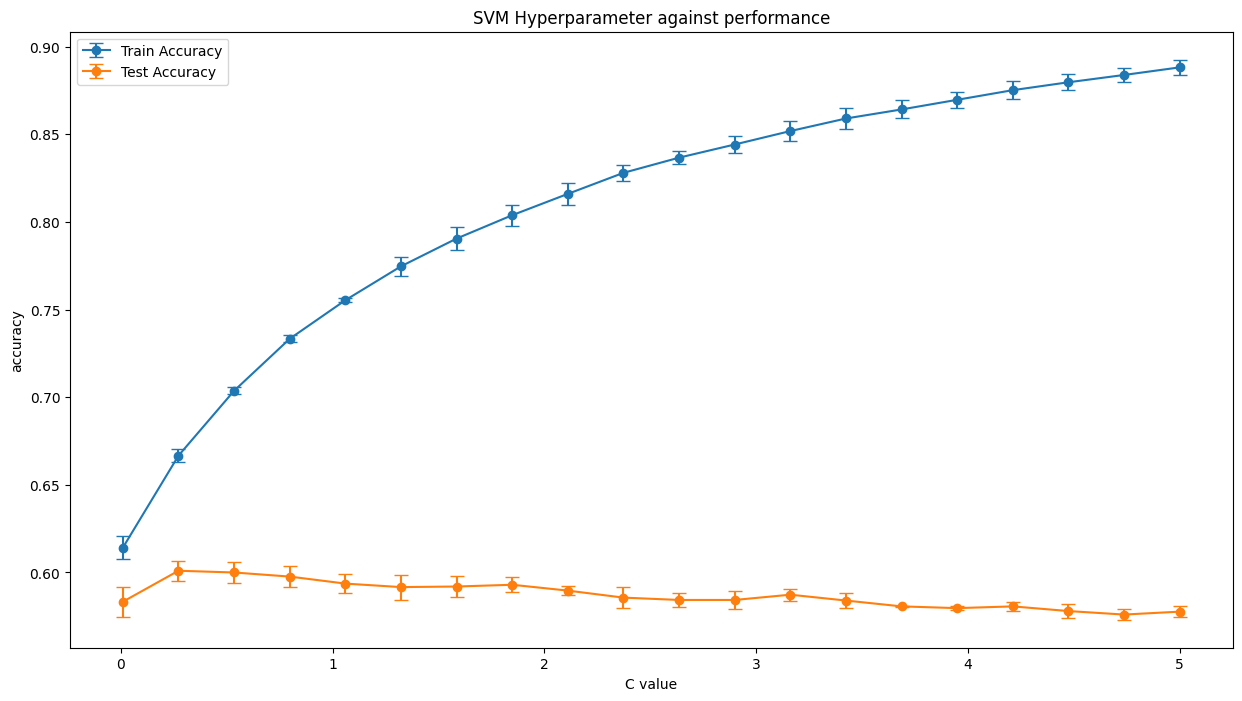

In [111]:
means_train_svm = []
means_test_svm = []
stds_train_svm = []
stds_test_svm = []

C_values = np.linspace(0.01,5,20)

for c in C_values:
  estimator = setup_pipe(preprocessor, SVC(C=c))
  results_train, results_test = evaluate(estimator)
  means_train_svm.append(np.mean(results_train))
  means_test_svm.append(np.mean(results_test))
  stds_train_svm.append(np.std(results_train))
  stds_test_svm.append(np.std(results_test))

hyperparameter_plot(C_values, means_train_svm, means_test_svm, stds_train_svm, stds_test_svm, 'SVM', 'C value')

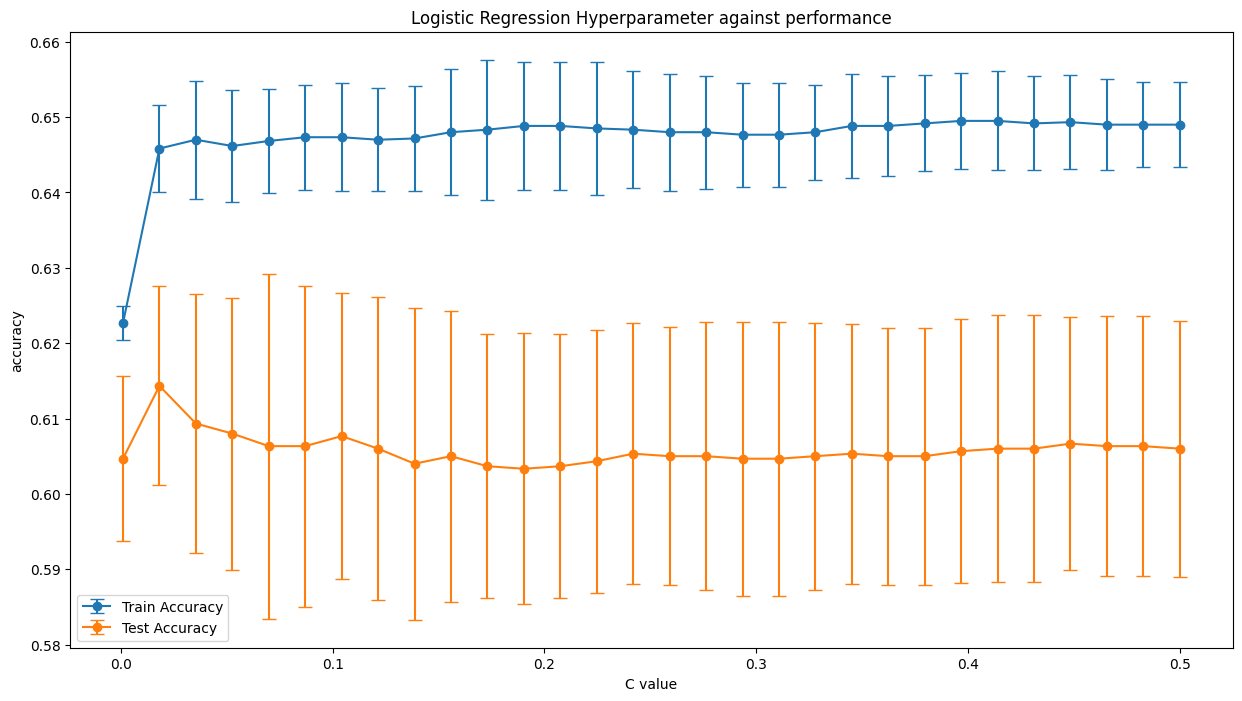

In [112]:
means_train_lr = []
means_test_lr = []
stds_train_lr = []
stds_test_lr = []

C_values = np.linspace(0.001,0.5,30)

for c in C_values:
  estimator = setup_pipe(preprocessor, LogisticRegression(C=c, max_iter=1000))
  results_train, results_test = evaluate(estimator)
  means_train_lr.append(np.mean(results_train))
  means_test_lr.append(np.mean(results_test))
  stds_train_lr.append(np.std(results_train))
  stds_test_lr.append(np.std(results_test))

hyperparameter_plot(C_values, means_train_lr, means_test_lr, stds_train_lr, stds_test_lr, 'Logistic Regression', 'C value')

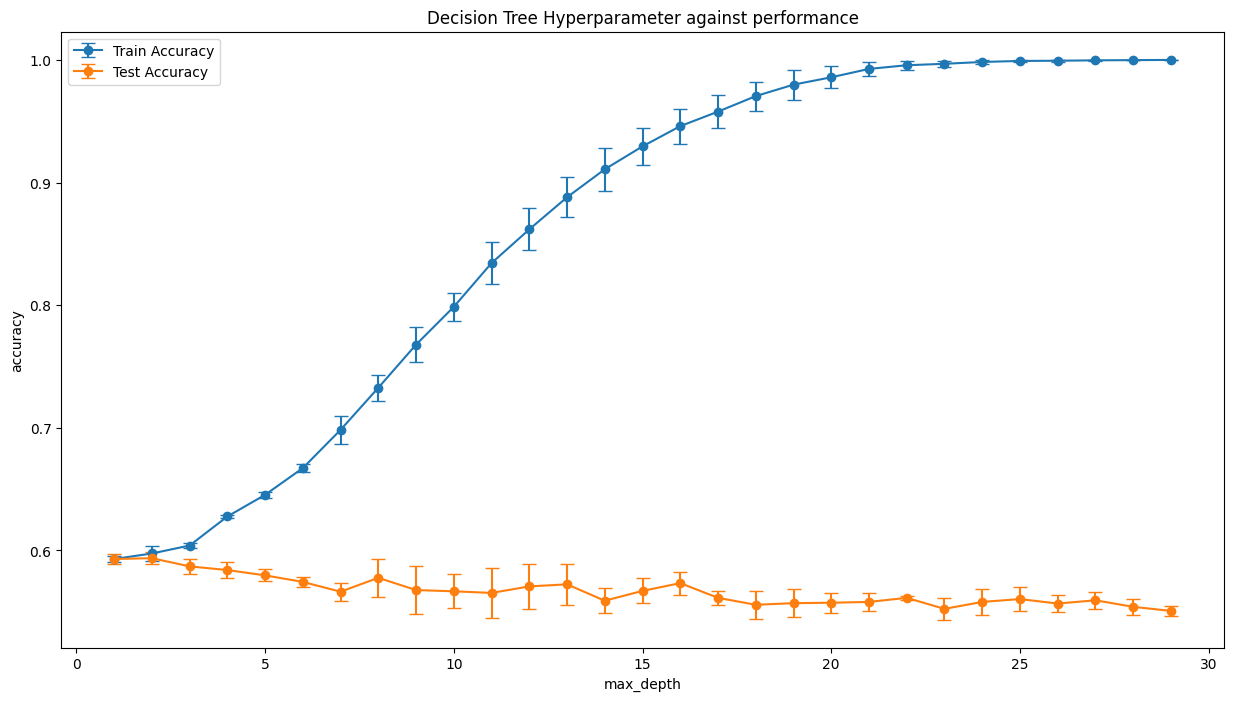

In [113]:
means_train_dt = []
means_test_dt = []
stds_train_dt = []
stds_test_dt = []

max_depth_values = np.arange(1,30,1)

for depth in max_depth_values:
  estimator = setup_pipe(preprocessor, DecisionTreeClassifier(max_depth=depth))
  results_train, results_test = evaluate(estimator)
  means_train_dt.append(np.mean(results_train))
  means_test_dt.append(np.mean(results_test))
  stds_train_dt.append(np.std(results_train))
  stds_test_dt.append(np.std(results_test))

hyperparameter_plot(max_depth_values, means_train_dt, means_test_dt, stds_train_dt, stds_test_dt, 'Decision Tree', 'max_depth')


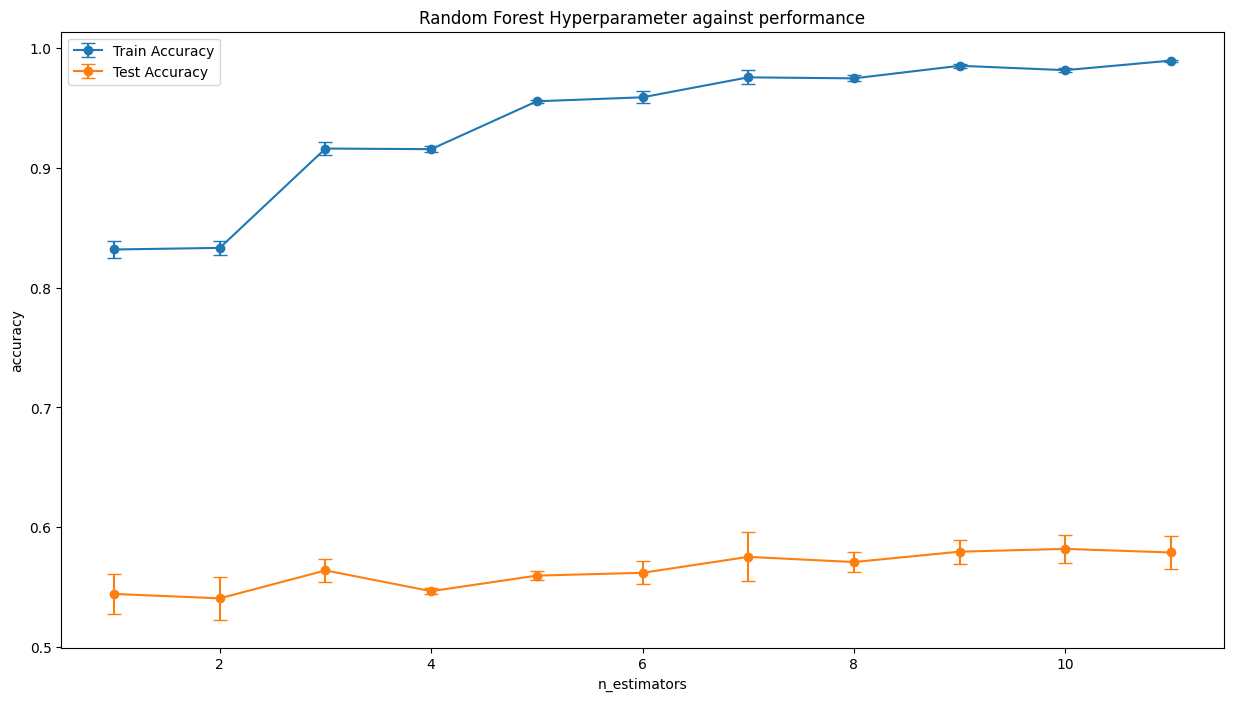

In [114]:
means_train_rf = []
means_test_rf = []
stds_train_rf = []
stds_test_rf = []

n_estimators_values = np.arange(1,12,1)

for n in n_estimators_values:
  estimator = setup_pipe(preprocessor, RandomForestClassifier(n_estimators=n))
  results_train, results_test = evaluate(estimator)
  means_train_rf.append(np.mean(results_train))
  means_test_rf.append(np.mean(results_test))
  stds_train_rf.append(np.std(results_train))
  stds_test_rf.append(np.std(results_test))

hyperparameter_plot(n_estimators_values, means_train_rf, means_test_rf, stds_train_rf, stds_test_rf, 'Random Forest', 'n_estimators')



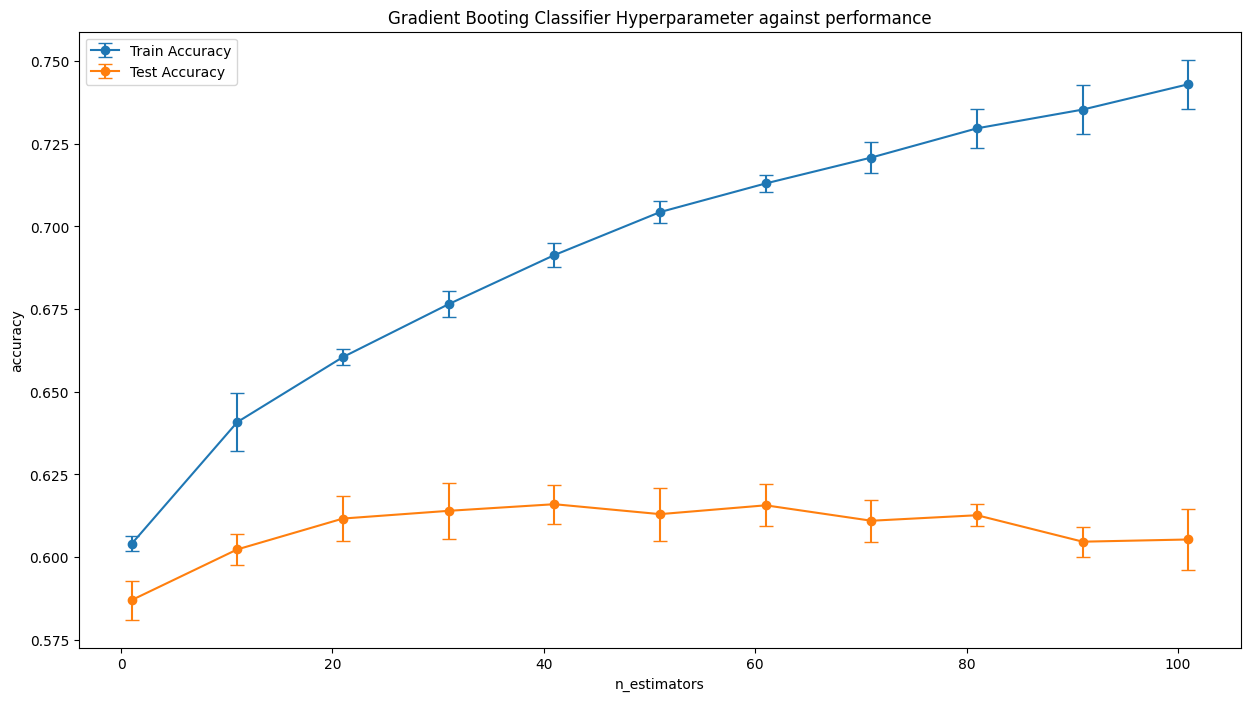

In [115]:
means_train_gb = []
means_test_gb = []
stds_train_gb = []
stds_test_gb = []

n_estimators_values = np.arange(1,102,10)

for n in n_estimators_values:
  estimator = setup_pipe(preprocessor, GradientBoostingClassifier(n_estimators=n))
  results_train, results_test = evaluate(estimator)
  means_train_gb.append(np.mean(results_train))
  means_test_gb.append(np.mean(results_test))
  stds_train_gb.append(np.std(results_train))
  stds_test_gb.append(np.std(results_test))

hyperparameter_plot(n_estimators_values, means_train_gb, means_test_gb, stds_train_gb, stds_test_gb, 'Gradient Booting Classifier', 'n_estimators')



**Analysis**:
- We find that as we increase hyperparameters all models start to overfit (blue line). Especially the Decision Tree is prune to overfit (Train Accuracy goes to 1).
- Logistic Regression is almost constant w.r.t to regularization parameter C with high uncertainty in the test performance.  
- Gradient Boosting is imporving for n_estimators up to around 40 and then starts to fluctuates afterwards

<a id='3.5'></a>
### 3.5 Performance Comparison

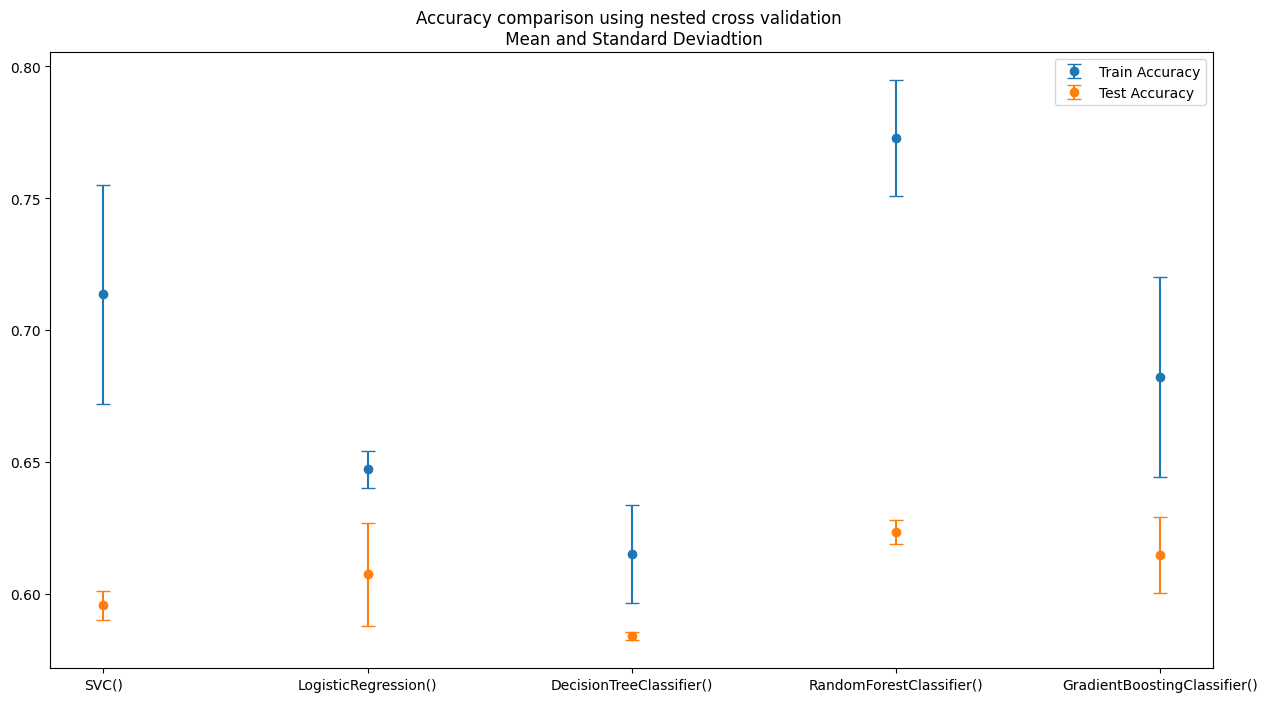

In [116]:
# Plotting the performance estimation grouped by classifier
plt.figure(figsize=(15,8))
plt.errorbar(x= list(map(str,models)), y = df_results['Mean Train Accuracy'], yerr=df_results['Standard Deviation Train'], linestyle='', fmt='o', capsize=5, label='Train Accuracy')
plt.errorbar(x= list(map(str,models)), y = df_results['Mean Test Accuracy'], yerr=df_results['Standard Deviation Test'], linestyle='', fmt='o', capsize=5, label='Test Accuracy')
plt.legend()
plt.title('Accuracy comparison using nested cross validation \n Mean and Standard Deviadtion')
plt.show()

In [117]:
df_results

,Best Model,Mean Test Accuracy,Standard Deviation Test,Mean Train Accuracy,Standard Deviation Train,Mean Test F1 Score,Standard Deviation F1 Score
0,SVC(C=0.8),0.595667,0.005558,0.713500,0.041354,0.570817,0.009672
1,"LogisticRegression(C=0.05, max_iter=1000)",0.607333,0.019602,0.647167,0.006980,0.585128,0.022297
2,"DecisionTreeClassifier(max_depth=3, min_sample...",0.584000,0.001633,0.615167,0.018661,0.503416,0.077284
3,"RandomForestClassifier(max_depth=10, min_sampl...",0.623333,0.004497,0.772833,0.021872,0.609214,0.003197
4,"GradientBoostingClassifier(max_depth=2, n_esti...",0.614667,0.014522,0.682333,0.037887,0.585168,0.014891


The best performing models were **Random Forest** and **Gradient Booting** (>0.61 Test Acc). Apparently Ensemble Tree models help to generalize better as compared linear models (SVM, Logistic Regression) or the Decision Tree.

From the previous analysis we found that the decision tree heavily overfits. By combining mutiple smaller trees Gradient Booting and Random Foresst are less prone to overfit and generalize better.

Additionally the ensemble model were able to identify more complex relationships as compared to the logistic regression.

The performance estimation for Random Forest is more robust than for Gradient Boosting (see standard deviation).

SVM performed suprisingly bad even though the rbf kernel could potentially capture non linear behaviour.

The test f1 scores are similar to the test accuracy scores indicating that all model perform similarily good (or bad) on both classes (readmitted and not readmitted). Only the Decision Tree has a significantly lower score in f1 than in accuracy. A closer look in the classification report showed that the Decsion tree struggled with predicting the `readmitted` class)

In general all models did not perform particularly well. More domain knowledge may be needed to apply more sophisticated feature engineering to make better use of the data.

<a id='4'></a>
# 4 Alternative pipeline
To investigate potential benefits of feature selection:

<a id='4.1'></a>
### 4.1 Pipline including Feature Selection

In [120]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel
from sklearn.svm import LinearSVC


In [121]:
# Adjusted pipeline from before for feature selection
def setup_alt_pipe(preprocessor, estimator, selection=None, p=0.8, k=10):
  '''
    Similar to setup_pipe() with potential feature selection
      'selection'. Can be one of the following:
        -'VarianceThreshold': Keeps only feature with variance above a threshold (default 0.8)
        -'SelectKBest': univariate feature selection based on K (default 10) best features, statistical test (f_classif)
        -'SelectFromModel': selectin most important features based on l1 regularized Linear SVC coefficients
    Returns:
      Pipeline object that can be used for fitting and prediction
  '''
  if selection is not None:

    if selection == 'VarianceThreshold':

      selector = VarianceThreshold(threshold=(p * (1 - p)))

    elif selection == 'SelectKBest':

      selector = SelectKBest(f_classif, k=k)

    elif selection == 'SelectFromModel':

      model = LinearSVC(C=0.01, penalty="l1", dual=False) # L1 norm feature selection, see sklearn
      selector = SelectFromModel(model)

    remove_constant = VarianceThreshold(threshold=(0)) # Removing features with constant values
    steps = [
        ('preprocess', preprocessor),
        ('remove_constant', remove_constant),
        ('select', selector),
        ('clf', estimator),
    ]

  else:
    steps = [
        ('preprocess', preprocessor),
        ('clf', estimator)
    ]

  pipe = Pipeline(steps)

  return pipe

In [122]:
def evaluate_all_models(selection=None, p=0.8, k=10, verbose=True):
  '''
    Potentially applying a selection method.
    Printing the Cross Validation Report and returns for all models:
      -mean test and train accuracies and their standard deviation
      -mean test f1 scores
      -the best performing models
  '''

  if verbose:
    if selection is not None:
      print('-'*20, 'Feature Selection Selection Method: ', selection, '-'*20)
    else:
      print('-'*20, 'No Feature Selection: ', '-'*20)

  # Setting up the preprocessor pipeline
  preprocessor = setup_preprocessor(df_preprocessed)

  #storing results
  means_train = []
  stds_train = []
  means_test = []
  stds_test = []
  final_models = []
  f1_means = []
  f1_stds_test = []

  for i, model in enumerate(models):

    #Parameter Grid
    param_grid = grids[i]

    #Printing the model
    if verbose:
      print(model)

    #Estimator pipeline, potentiall including feature selection
    estimator = setup_alt_pipe(preprocessor, model, selection=selection, p=0.8, k=10)

    # Nested Cross Validation
    final_model, acc_results_train, acc_results_test, f1_results_test = cv_nested(estimator, param_grid, verbose=verbose)

    # Train Accuracy
    model_mean_train = np.mean(acc_results_train)
    means_train.append(model_mean_train)
    model_std_train = np.std(acc_results_train)
    stds_train.append(model_std_train)

    # Test Accuracy
    model_mean_test = np.mean(acc_results_test)
    means_test.append(model_mean_test)
    model_std_test = np.std(acc_results_test)
    stds_test.append(model_std_test)

    # F1 score
    model_f1_mean = np.mean(f1_results_test)
    f1_means.append(model_f1_mean)
    f1_model_std_test = np.std(f1_results_test)
    f1_stds_test.append(f1_model_std_test)

    # Best performing Model
    final_models.append(final_model)

    if verbose:
      print('Mean Train Acc: %.3f (Std: %.3f), Mean Test Acc: %.3f (Std: %.3f), Mean Test f1: %.3f (Std: %.3f)'
          % (model_mean_train, model_std_train, model_mean_test, model_std_test, model_f1_mean, f1_model_std_test), '\n')

  return means_train, stds_train, means_test, stds_test, f1_means, f1_stds_test, final_models



<a id='4.2'></a>
### 4.2 Model Evaluation with Feature Selection
Using the alternative pipeline to test if adding a features selection approach leads to an improvement in performance with respect to the performance obtained in the previous tasks. 

In [ ]:
means_train, stds_train, means_test, stds_test, f1_means, f1_stds_test, final_models = evaluate_all_models(

    selection='VarianceThreshold', p=0.9

    )

df_results_VarianceThreshold = pd.DataFrame({
  'Best Model':list(map(str,[model['clf'] for model in final_models])),
  'Mean Test Accuracy':means_test,
  'Standard Deviation Test':stds_test,
  'Mean Train Accuracy':means_train,
  'Standard Deviation Train':stds_train,
  'Mean Test F1 Score': f1_means,
  'Standard Deviation F1 Score': f1_stds_test,
})

-------------------- Feature Selection Selection Method:  VarianceThreshold --------------------
SVC()
-Fold 1: Train Acc: 0.620, Test Acc: 0.601, Test f1: 0.521, Best hyperparamters  = {'clf__C': 0.8, 'clf__kernel': 'linear'}
-Fold 2: Train Acc: 0.630, Test Acc: 0.588, Test f1: 0.547, Best hyperparamters  = {'clf__C': 0.8, 'clf__kernel': 'linear'}
-Fold 3: Train Acc: 0.628, Test Acc: 0.599, Test f1: 0.537, Best hyperparamters  = {'clf__C': 1, 'clf__kernel': 'linear'}
Mean Train Acc: 0.626 (Std: 0.004), Mean Test Acc: 0.596 (Std: 0.006), Mean Test f1: 0.535 (Std: 0.011) 

LogisticRegression()
-Fold 1: Train Acc: 0.630, Test Acc: 0.612, Test f1: 0.579, Best hyperparamters  = {'clf__C': 0.05, 'clf__max_iter': 1000}
-Fold 2: Train Acc: 0.639, Test Acc: 0.597, Test f1: 0.567, Best hyperparamters  = {'clf__C': 0.1, 'clf__max_iter': 1000}
-Fold 3: Train Acc: 0.631, Test Acc: 0.601, Test f1: 0.574, Best hyperparamters  = {'clf__C': 1, 'clf__max_iter': 1000}
Mean Train Acc: 0.633 (Std: 0.004),

In [ ]:
means_train, stds_train, means_test, stds_test, f1_means, f1_stds_test, final_models = evaluate_all_models(

    selection='SelectKBest', k=20

    )

df_results_selectKBest = pd.DataFrame({
  'Best Model':list(map(str,[model['clf'] for model in final_models])),
  'Mean Test Accuracy':means_test,
  'Standard Deviation Test':stds_test,
  'Mean Train Accuracy':means_train,
  'Standard Deviation Train':stds_train,
  'Mean Test F1 Score': f1_means,
  'Standard Deviation F1 Score': f1_stds_test,
})

-------------------- Feature Selection Selection Method:  SelectKBest --------------------
SVC()
-Fold 1: Train Acc: 0.631, Test Acc: 0.600, Test f1: 0.548, Best hyperparamters  = {'clf__C': 0.6, 'clf__kernel': 'rbf'}
-Fold 2: Train Acc: 0.642, Test Acc: 0.606, Test f1: 0.588, Best hyperparamters  = {'clf__C': 0.6, 'clf__kernel': 'rbf'}
-Fold 3: Train Acc: 0.645, Test Acc: 0.603, Test f1: 0.535, Best hyperparamters  = {'clf__C': 1, 'clf__kernel': 'rbf'}
Mean Train Acc: 0.640 (Std: 0.006), Mean Test Acc: 0.603 (Std: 0.002), Mean Test f1: 0.557 (Std: 0.023) 

LogisticRegression()
-Fold 1: Train Acc: 0.629, Test Acc: 0.595, Test f1: 0.556, Best hyperparamters  = {'clf__C': 0.05, 'clf__max_iter': 1000}
-Fold 2: Train Acc: 0.620, Test Acc: 0.617, Test f1: 0.580, Best hyperparamters  = {'clf__C': 0.05, 'clf__max_iter': 1000}
-Fold 3: Train Acc: 0.622, Test Acc: 0.613, Test f1: 0.562, Best hyperparamters  = {'clf__C': 0.05, 'clf__max_iter': 1000}
Mean Train Acc: 0.624 (Std: 0.004), Mean Test 

In [ ]:
means_train, stds_train, means_test, stds_test, f1_means, f1_stds_test, final_models = evaluate_all_models(

    selection='SelectFromModel'

    )


df_results_SelectFromModel = pd.DataFrame({
  'Best Model':list(map(str,[model['clf'] for model in final_models])),
  'Mean Test Accuracy':means_test,
  'Standard Deviation Test':stds_test,
  'Mean Train Accuracy':means_train,
  'Standard Deviation Train':stds_train,
  'Mean Test F1 Score': f1_means,
  'Standard Deviation F1 Score': f1_stds_test,
})

-------------------- Feature Selection Selection Method:  SelectFromModel --------------------
SVC()
-Fold 1: Train Acc: 0.676, Test Acc: 0.592, Test f1: 0.551, Best hyperparamters  = {'clf__C': 0.8, 'clf__kernel': 'rbf'}
-Fold 2: Train Acc: 0.635, Test Acc: 0.608, Test f1: 0.575, Best hyperparamters  = {'clf__C': 0.6, 'clf__kernel': 'linear'}
-Fold 3: Train Acc: 0.658, Test Acc: 0.600, Test f1: 0.527, Best hyperparamters  = {'clf__C': 1, 'clf__kernel': 'rbf'}
Mean Train Acc: 0.656 (Std: 0.017), Mean Test Acc: 0.600 (Std: 0.007), Mean Test f1: 0.551 (Std: 0.019) 

LogisticRegression()
-Fold 1: Train Acc: 0.632, Test Acc: 0.603, Test f1: 0.579, Best hyperparamters  = {'clf__C': 0.5, 'clf__max_iter': 1000}
-Fold 2: Train Acc: 0.634, Test Acc: 0.616, Test f1: 0.594, Best hyperparamters  = {'clf__C': 0.05, 'clf__max_iter': 1000}
-Fold 3: Train Acc: 0.615, Test Acc: 0.592, Test f1: 0.551, Best hyperparamters  = {'clf__C': 1, 'clf__max_iter': 1000}
Mean Train Acc: 0.627 (Std: 0.009), Mean Te

<a id='4.3'></a>
### 4.3 Comparion of Models Performance
Creating a plot to show the performance of the different models 

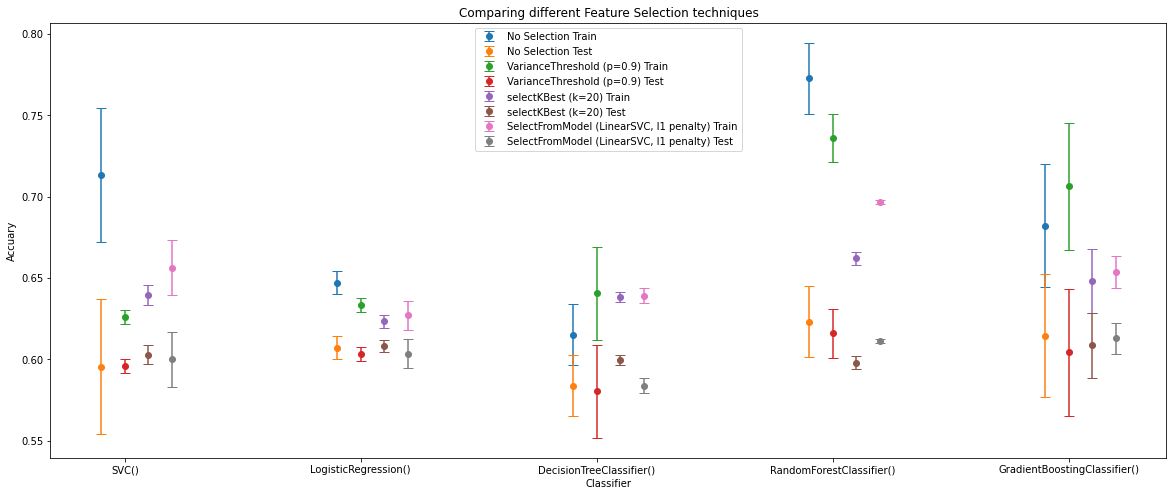

In [ ]:
# Creating an error barplot to compare the different feature selection methods grouped by classifier

barWidth = 0.1

# set heights of bars
y1_train = df_results['Mean Train Accuracy']
y2_train = df_results_VarianceThreshold['Mean Train Accuracy']
y3_train = df_results_selectKBest['Mean Train Accuracy']
y4_train = df_results_SelectFromModel['Mean Train Accuracy']

y1_test = df_results['Mean Test Accuracy']
y2_test = df_results_VarianceThreshold['Mean Test Accuracy']
y3_test = df_results_selectKBest['Mean Test Accuracy']
y4_test = df_results_SelectFromModel['Mean Test Accuracy']

yerr1_train = df_results['Standard Deviation Train']
yerr2_train = df_results_VarianceThreshold['Standard Deviation Train']
yerr3_train = df_results_selectKBest['Standard Deviation Train']
yerr4_train = df_results_SelectFromModel['Standard Deviation Train']

yerr1_test = df_results['Standard Deviation Train']
yerr2_test = df_results_VarianceThreshold['Standard Deviation Train']
yerr3_test = df_results_selectKBest['Standard Deviation Train']
yerr4_test = df_results_SelectFromModel['Standard Deviation Train']

# Set position of bar on X axis
x1 = np.arange(len(y1_train))
x2 = [x + barWidth for x in x1]
x3 = [x + barWidth for x in x2]
x4 = [x + barWidth for x in x3]


plt.figure(figsize=(20,8))

# Make the plot
plt.errorbar(x= x1, y = y1_train, yerr=yerr1_train, linestyle='', fmt='o', capsize=5, label='No Selection Train')
plt.errorbar(x= x1, y = y1_test, yerr=yerr1_test, linestyle='', fmt='o', capsize=5, label='No Selection Test')

plt.errorbar(x= x2, y = y2_train, yerr=yerr2_train, linestyle='', fmt='o', capsize=5, label='VarianceThreshold (p=0.9) Train')
plt.errorbar(x= x2, y = y2_test, yerr=yerr2_test, linestyle='', fmt='o', capsize=5, label='VarianceThreshold (p=0.9) Test')

plt.errorbar(x= x3, y = y3_train, yerr=yerr3_train, linestyle='', fmt='o', capsize=5, label='selectKBest (k=20) Train')
plt.errorbar(x= x3, y = y3_test, yerr=yerr3_test, linestyle='', fmt='o', capsize=5, label='selectKBest (k=20) Test')

plt.errorbar(x= x4, y = y4_train, yerr=yerr4_train, linestyle='', fmt='o', capsize=5, label='SelectFromModel (LinearSVC, l1 penalty) Train')
plt.errorbar(x= x4, y = y4_test, yerr=yerr4_test, linestyle='', fmt='o', capsize=5, label='SelectFromModel (LinearSVC, l1 penalty) Test')

# Add xticks on the middle of the group bars
plt.xlabel('Classifier')
plt.ylabel('Accuary')
plt.xticks([r + barWidth for r in range(len(models))], list(map(str,models)))
plt.title('Comparing different Feature Selection techniques')

# Create legend and show graphic
plt.legend()
plt.show()

We implemented three different feature selection approaches:


1.   **VarianceThreshold**:

  Keeping only feature above a certain variance thershold (default 0.8).

2.   **SelectKBest**:

  Based on a statistical test, keeping the K most importanct features (K=10 default)

3.  **SelectFromModel**:

  Prefit on a specific model (here LinearSVC with l1 regularization) and keeping those features with positve coefficients (similar to LASSO selection).

**Results**:

We find that none of the feature selection techniques applied helped improving the performance. The orange bar (no feature selection test accuracy) is above the other test bars. Only for the Decision Tree SelectKBest improved the performance slightly.

However VarianceThreshold and SelectKBest significantly decreased the computation time which is worth mentioning considering the size of the original dataset. (SelectFromModel was simlilarily slow due to prefitting)

Concluding, feature selection did not help to improve the performance but can be helpful for scalability purposes.


<a id='5'></a>
# 5 Model Interpretation 


<a id='5.1'></a>
### 5.1 Visualizing Feature Importances
Creating figures/plots to show the relative importance of different features for the model. 

From previous results we find that **Random Forest** and **Gradient Boosting** performed best.

In [ ]:
# Original results without feature selection
means_train, stds_train, means_test, stds_test, f1_means, f1_stds_test, final_models = evaluate_all_models(verbose=False)

df_results = pd.DataFrame({
  'Best Model':list(map(str,[model['clf'] for model in final_models])),
  'Mean Test Accuracy':means_test,
  'Standard Deviation Test':stds_test,
  'Mean Train Accuracy':means_train,
  'Standard Deviation Train':stds_train,
  'Mean Test F1 Score': f1_means,
  'Standard Deviation F1 Score': f1_stds_test,
})

In [ ]:
#Extracting the fitted classifiers from the pipeline objects
svm_best = final_models[0]['clf']
lr_best = final_models[1]['clf']
dt_best = final_models[2]['clf']
rf_best = final_models[3]['clf']
gb_best = final_models[4]['clf']

In [ ]:
# Extracting feture names from pipeline object
feature_names = final_models[0].named_steps['preprocess'].get_feature_names_out()

In [ ]:
#Removing irrelavent bits from the feature_names
feature_names = [name.split('__')[1] for name in feature_names]

#Target Variable names
class_names = ['Not readmitted', 'readmitted']

In [ ]:
# Similar to CW1 COMP0195

#For linear models with .coef_ attribute
def feature_importance_linear(model):
  '''
    returns a sorted dataframe with feature names and their corresponing imortance for a specific model
  '''
  feat_dict= {}
  for col, val in sorted(zip(feature_names, model.coef_[0]),key=lambda x:x[1],reverse=True):
    feat_dict[col]=val

  feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
  return feat_df

#For tree models with .feature_importances_ attribute
def feature_importance_tree(model):
  '''
    returns a sorted dataframe with feature names and their corresponing imortance for a specific model
  '''
  feat_dict= {}
  for col, val in sorted(zip(feature_names, model.feature_importances_),key=lambda x:x[1],reverse=True):
    feat_dict[col]=val

  feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
  return feat_df

# plotting the n most important features for a model in a horizontal barplot (n=10 deafult)
def plot_feature_importance(df, model_name, n=10):
  plt.figure(figsize=(8,6))
  y_pos = np.arange(len(df['Feature'][:n]))
  plt.barh(y_pos, np.sort(df['Importance'][:n]))
  plt.title(f'Feature Importance for {model_name}')
  plt.ylabel('Feature')
  plt.xlabel('Importance')
  plt.yticks(y_pos, labels=(np.flip(np.array(df['Feature'][:10]))))


In [ ]:
df_rf_best_imp = feature_importance_tree(rf_best)
df_rf_best_imp.head(10)

,Feature,Importance
0,number_inpatient,0.128989
1,number_outpatient,0.088112
2,num_medications,0.078532
3,num_lab_procedures,0.050433
4,number_emergency,0.044770
5,time_in_hospital,0.040815
6,num_procedures,0.035309
7,age,0.034823
8,number_diagnoses,0.031605
9,admission_source_id_Emergency,0.015657


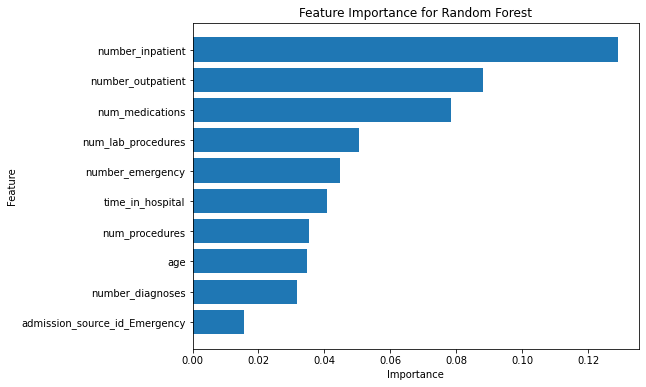

In [ ]:
plot_feature_importance(df_rf_best_imp, 'Random Forest')

In [ ]:
df_gb_best_imp = feature_importance_tree(gb_best)
df_gb_best_imp.head(10)

,Feature,Importance
0,number_inpatient,0.299265
1,number_outpatient,0.152163
2,num_medications,0.089544
3,num_procedures,0.062491
4,pioglitazone,0.043608
5,number_emergency,0.039131
6,diag_1_Neoplasms,0.032909
7,number_diagnoses,0.029552
8,num_lab_procedures,0.024536
9,age,0.024087


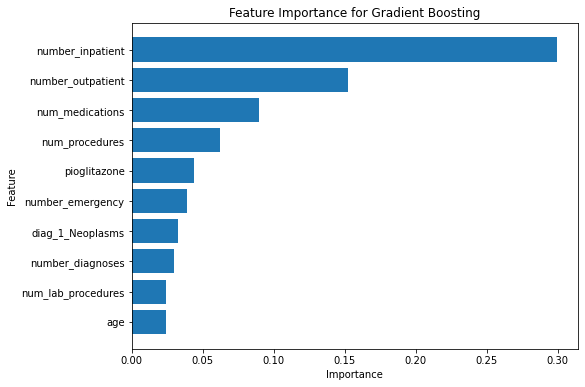

In [ ]:
plot_feature_importance(df_gb_best_imp, 'Gradient Boosting')

In [ ]:
import shap

In [ ]:
X_transformed = preprocessor.fit_transform(X)

In [ ]:
explainer_rf = shap.TreeExplainer(rf_best)

shap_values_rf = explainer_rf.shap_values(X_transformed)


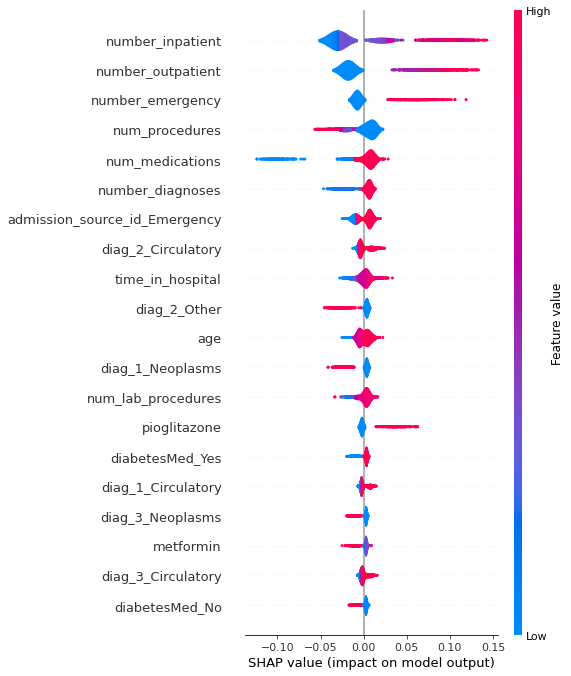

In [ ]:
shap.summary_plot(shap_values_rf[1], X_transformed, plot_type='violin', feature_names=feature_names)

In [ ]:
explainer_gb = shap.TreeExplainer(gb_best)

shap_values_gb = explainer_gb.shap_values(X_transformed)


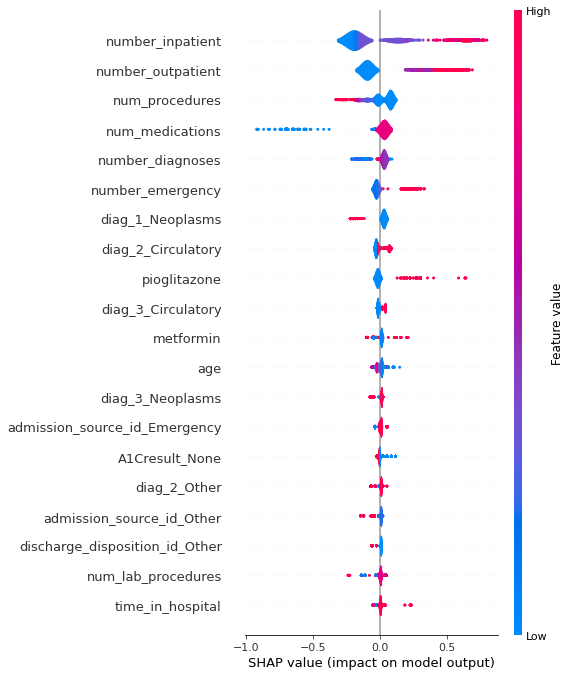

In [ ]:
shap.summary_plot(shap_values_gb, X_transformed, plot_type='violin', feature_names=feature_names)

<a id='5.2'></a>
### 5.2 Interpretation with respect to the task

For the **Random Forest** the most important features are:

- `num_inpatient`
- `num_outpatient`
- `num_medications`
- `num_lab_procedures`
- `number_emergency`
- `time_in_hospital`
- `age`

Considering the task (predicting if a patient is readmitted to hospital or not) the fact that number of encounters with the hospital in the preceeding year (inpatient, outpatient and emergency) was important for the Random Forest seems highly logical. The model was able to identify that relationship and use those features in the decision boundary.

It is also reasonable that the number of medications taken by the patient will correlate with the probability of readmission. Someone that is dependent on a high number of drugs will be more likely to be readmitted to hospital than someone who used less medication.

Lastly the more time a patient has spent in the hospital the higher the probability of readmission. Similarily the older a patient the more likely it is that the patient will be readmitted.

Shapley values is another model agnostic way for interpretability on a local level (see, [IntrepretableML Book](https://christophm.github.io/interpretable-ml-book/shapley.html)). Using the summary plots from the shap library we can illustrate the distribution of all instances w.r.t to the models outcome. For example high numbers of  encounters with the hospital results in higher likelihood of being predicted `readmitted`.

In summary, Random Forest uses soley numeric features in its decision boundary for predicting readmission. The relationships seem reasonable from a medical point of view. However there might be spurious correlations involved as the numeric features are quite strongly correlated (see plot, e.g. `num_medications` and `time_in_hospital`) which makes it difficult to accurately determine the importance of each feature.

For the **Gradient Booting** the most important features are:

- `num_inpatient`
- `num_outpatient`
- `num_medications`
- `num_procedures`
- `pioglitazone`
- `number_emergency`
- `diag_1_Neoplasms`
- `number_diagnoses`

The same analysis holds for Gradient Boosting. See next task for comparison.

<a id='5.3'></a>
### 5.3 Similarities and Differences between the models


Since both best performing models are ensemble models based on decision trees it is not surprising that the most important features for both models overlap. Both models rely their decision mostly on number of preceeding encounters a patient.

The difference between both is that random Forest builds multiple decision trees independently, while Gradient boosting builds decision trees sequentially by focusing on the mistakes of the previous tree. This results to some important features for gradient boosting that seem to make no sense with respect to the task. For example the drug `pioglitazone` or the `diag_1_Neoplasms` diagnosis has high importance for the gradient boosting. Without being an expert in the medical domain it seems strange to predict readmission based on a single drug or diagnosis. Some spurious correlations might be involved.

Since both models are ensemble models consisting of many decision trees it is hard to interpret the actualy decsion precedure. Decsion Trees however are more interpretable as we can plot the actual tree structure and thereby follow the model's decision path. An illustration is made in the code below. Note that the numeric values are standardized and dont reflect the actual values.

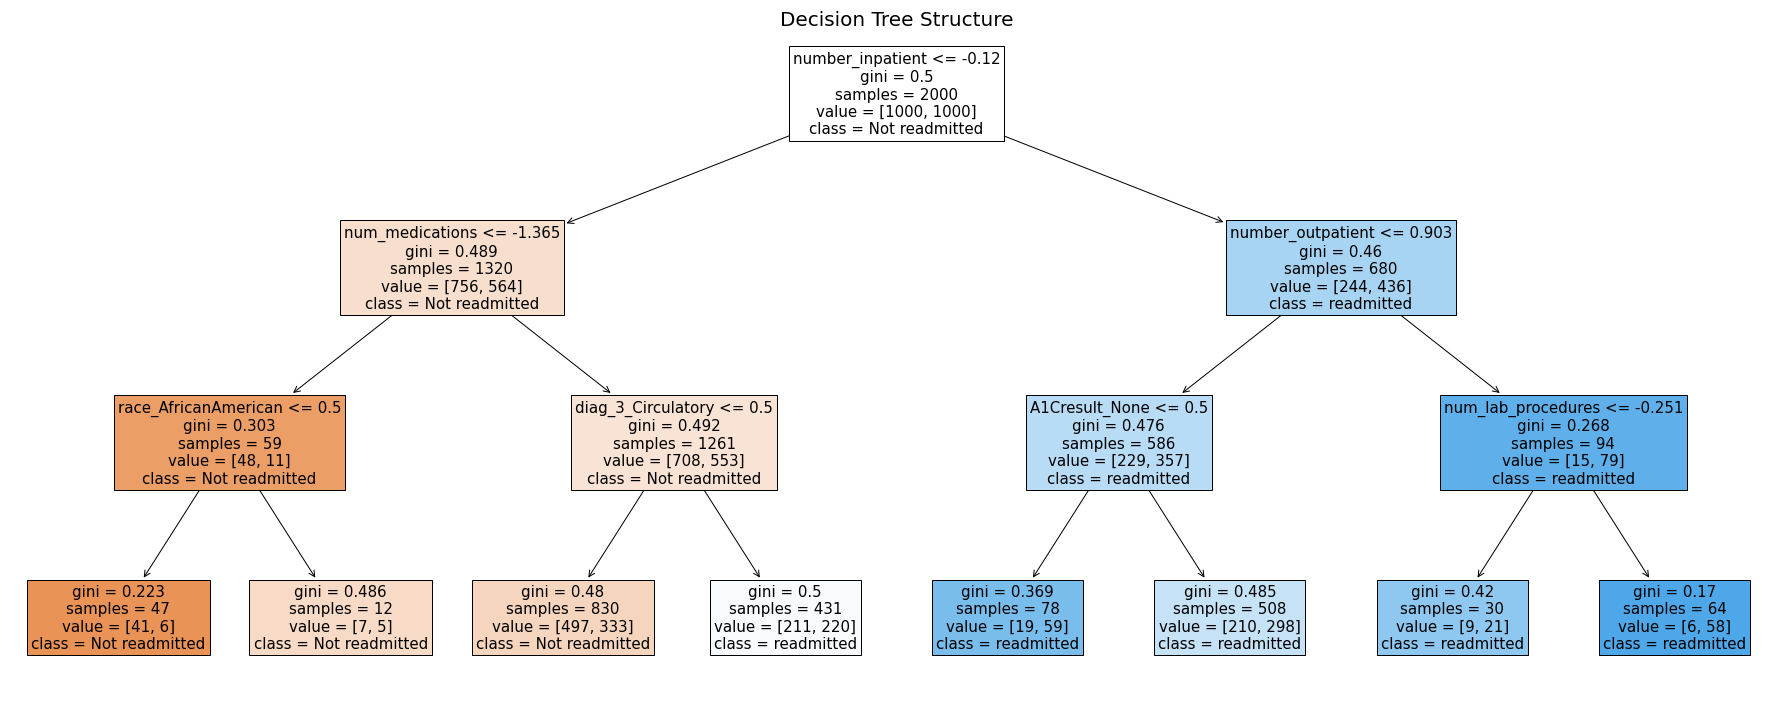

In [ ]:
#Plotting the Decision Tree
fig = plt.figure(figsize=(25,10))
plot_tree(dt_best, filled=True, feature_names=feature_names, class_names=class_names, fontsize=15)
plt.tight_layout()
plt.suptitle("Decision Tree Structure", fontsize=20)
plt.show()

<a id='6'></a>
# 6 Limitations and potential Solutions 
In this section we consider potential limitations with both the dataset and the models/pipelines  

<a id='6.1'></a>
### 6.1 Limitations with the dataset
  

- Obviously the low performance of all classifiers indicates that the **data lacks patterns** in its raw form.
- **Irrelavent features**: For example most medication features have almost zero varianace (`Not taken`). They might decrease the model's performance.
- There are a lot of **missing values** in the `weight` feature (97%) which would be potentially be a good predictor for readmission of diabetic patients.
- The dataset has categorical features with **a lot of categories** (e.g. diag features, dismission_type, etc.) which are difficult to encode.
- Some features are quite strongly **correlated** (see plot) which might lead to misleading feature importances.
- From the descriptive analysis we find that there is **no linear relationship** between the target readmission and the features which can limit the models' performance (at least for the linear model logistic regression)
- Lastly the data was collected from 1998 to 2008 which means in a real application the model would rely on **outdated** training data (e.g. outdated drugs, outdated measurement techniques). The data might no longer be representative of the current distribution which could lead to decreased performance if applied in real patients today.



<a id='6.2'></a>
### 6.2 Improvents in the dataset


- **Less missing values**: For example weight would be a highly valuable features since the task is about diabetic patients.
- **More meaningful features**. What would help is to include historic information on a patient such as:
  - long term medication
  - chronic diseases
  - previous hospital encounters
- **Feature engineering by domain experts**. For example there are over 700 ICD codes in the diagnosis features. They shoud be clustered appropriately. (I tried that but there may be more reasoable ways to do it). There might also be a smarter way to treat all the medication features. Maybe experts could put a weight on them with respect to their relevance for diabetes treatment.
- A **body mass index feature** could help as well but the dataset lacks information on weight and height.
- If possible **more recent data** should be used for training to represent the current distribution and avoid using outdated features.
- **Accounting for Hospital Group Structure:** Since the data is based on different hospitals it would help to include information about which hospital a patient is associated with. This way we could use grouped cross validation to take the correlation structures better into account.

<a id='6.3'></a>
### 6.3 Limitations with the model and pipeline

- The pipeline uses nested cross validation which has two caveats:

  - **Computationally expensive**. The model has to be fit `n*m*l` times (`n`: number of combinations for grid search, `m`: number of folds for inner loop, `l`: number of folds for outer loop). I had to use a small subset and I could only test for a small number of hyperparameter of the original data to compute the models in reasonable time
  - There is **no single final model** in each round of cross validation in the outer loop an new set of hyperparameter is performing best

- We use **GridSearch** which is the most simple way of hyperparameter tuning. It is not effective in finding the best set of hyperparameter due to its straight forward apprach of testing each combination.

- Logistic Regression is **underfitting**. Both train and test accuracy is fairly low. Probably the model is to simple to capture more complex relationships.

- Using a pipeline helped the workflow but the whole process becomes **less transparent** and harder to debug (e.g. extracting encoded feature names).

- **Reduced interpretability** of feature values due to scaling. For example when plotting the decision tree the threshold value for the decision boundary are not intepretable (e.g. `num_medications < -1.3`). While SVM and Logistic regression benefit from feature scaling the tree models are scaling invariant.


  

<a id='6.4'></a>
### 6.4 Alternative Models or pipelines

Potential solutions are:

- We could use more sophisticated hyperparamter tuning methods such as **random search** or **baysian optimization**.
- Using a more simple Cross Validation technique such as **Repeated Stratified Cross Validation**. This way there would also be only a single optimal classifier (at the cost of only using one test set)
- For **more transparency** the preprocessing steps (encoding, scaling) and model selection could be decoupled from each other.
- Since the tree models (Decsion Tree, Random Forest) are scaling invariant we could leave out the scaling step in the preprocessing pipeline for those models in order to **increase the interpretability** of the features
- Lastly, **more computation power** would help to use more data for training and tuning more hyperparamters which could help to imporve the models' performance